## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import platform
import re
import optuna
from sklearn.ensemble import VotingRegressor
from statsmodels.api import add_constant
from sklearn.feature_selection import mutual_info_regression
from matplotlib import font_manager, rc
from scipy.stats import shapiro, spearmanr, kruskal
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import BallTree
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../data/Original_data/train.csv")
test = pd.read_csv("../data/Original_data/test.csv")
xy = pd.read_csv("../data/Preprocessed_data/xy-V2.csv")
map_train = pd.read_csv("../data/Preprocessed_data/Train_Missing_Data.csv")
map_test = pd.read_csv("../data/Preprocessed_data/Test_Missing_Data.csv")
bus = pd.read_csv("../data/Original_data/bus_feature.csv")
subway = pd.read_csv("../data/Original_data/subway_feature.csv")
crime_pop_money = pd.read_csv("../data/Preprocessed_data/Metrics.csv", encoding='EUC-kr')
garden = pd.read_csv("../data/Preprocessed_data/Garden.csv", encoding='EUC-kr')
school = pd.read_csv("../data/Preprocessed_data/School.csv")
movie = pd.read_csv("../data/Preprocessed_data/Movie.csv")
hospital = pd.read_csv("../data/Preprocessed_data/Hospital.csv")
mart = pd.read_csv("../data/Preprocessed_data/Mart.csv")
price = pd.read_csv("../data/Preprocessed_data/주택가격-지가변동-대출금리-인플레이션.csv")

print(f"Train Data: {train.shape}")
print(f"Test Data: {test.shape}")
print(f"XY Data: {xy.shape}")
print(f"map_Train Data: {map_train.shape}")
print(f"map_Test Data: {map_test.shape}")
print(f"Bus Data: {bus.shape}") 
print(f"Subway Data: {subway.shape}")
print(f"Crime_pop_money Data: {crime_pop_money.shape}")
print(f"Garden Data: {garden.shape}")
print(f"School Data: {school.shape}")
print(f"Hospital Data: {hospital.shape}")
print(f"Moive Data: {movie.shape}")
print(f"Mart Data: {mart.shape}")
print(f"Price Data: {price.shape}")

Train Data: (1118822, 52)
Test Data: (9272, 51)
XY Data: (8196, 5)
map_Train Data: (1118822, 10)
map_Test Data: (9272, 10)
Bus Data: (12584, 6)
Subway Data: (768, 5)
Crime_pop_money Data: (25, 22)
Garden Data: (141, 4)
School Data: (1320, 6)
Hospital Data: (21485, 6)
Moive Data: (93, 5)
Mart Data: (594, 5)
Price Data: (5025, 10)


In [3]:
target = train['target']
train_df = train.drop(columns=['target']).copy()
train_df['original_index'] = train_df.index

test_df = test.copy()
test_df['original_index'] = test_df.index

train_df['label'] = 'Train' # train
test_df['label'] = 'Test' # tets

df = pd.concat([train_df, test_df], ignore_index=True)
print(f"df: {df.shape}")
df.head()

df: (1128094, 53)


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,original_index,label
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0,Train
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,1,Train
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,2,Train
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,3,Train
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,4,Train


In [4]:
xy.head(3)

,구,동,번지,위도,경도
0,강남구,역삼동,762,37.495583,127.046917
1,강북구,수유동,282-20,37.646608,127.014052
2,구로구,구로동,107-4,37.498664,126.891127


In [5]:
map_train.head(3)

,k-전체동수,주차대수,건축면적,k-주거전용면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-관리비부과면적,k-연면적,k-전체세대수
0,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
1,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0
2,8.0,262.0,4858.0,20204.0,20.0,250.0,0.0,22637.0,22637.0,270.0


In [6]:
bus.head(3)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로


In [7]:
subway.head(3)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868


In [8]:
crime_pop_money.head(3)

,구,총인구수,남성_비율,여성_비율,어린이_비율,10대_비율,20대_비율,30대_비율,40대_비율,50대_비율,...,총합_발생,살인율,강도율,절도율,폭력율,살인_검거율,강도_검거율,절도_검거율,폭력_검거율,총_검거율
0,강남구,508057,0.478340,0.521660,0.059639,0.109856,0.119428,0.145663,0.181013,0.159612,...,3571,0.000028,0.000039,0.001334,0.004881,0.785714,0.9,0.836283,0.517742,0.871465
1,강동구,447617,0.488053,0.511947,0.068550,0.083525,0.119991,0.150548,0.160959,0.154228,...,1569,0.000009,0.000011,0.000322,0.003744,1.500000,0.8,0.847222,0.584726,0.881453
2,강북구,284998,0.480624,0.519376,0.041948,0.066597,0.136233,0.123931,0.138787,0.170928,...,1431,0.000025,0.000004,0.000495,0.003218,1.000000,1.0,0.723404,0.796074,0.909853


In [9]:
garden.head(3)

,구,공원명,위도,경도
0,중구,남산공원,37.550140,126.990377
1,강동구,길동생태공원,37.540394,127.154779
2,성동구,서울숲,37.543072,127.041798


In [10]:
school.head(3)

,구,학교명,학교구분명,소재지도로명주소,위도,경도
0,성동구,한양여자대학교,전문대학,"서울특별시 성동구 살곶이길 200 (사근동, 한양여자대학)",37.557918,127.049322
1,강서구,한국폴리텍 I 대학 서울강서캠퍼스,전문대학,"서울특별시 강서구 우장산로10길 112 (화곡동, 한국폴리텍Ⅰ서울강서대학)",37.549242,126.842445
2,용산구,한국폴리텍 I 대학 서울정수캠퍼스,전문대학,"서울특별시 용산구 보광로 73 (보광동, 한국폴리텍1대학서울정수캠퍼스)",37.529975,126.996817


In [11]:
movie.head(3)

,구,영화상영관명,주소,위도,경도
0,강동구,CGV 고덕강일,서울특별시 강동구 고덕동 353-23 번지 3층,37.566262,127.157531
1,은평구,CGV 불광,서울특별시 은평구 대조동 240 번지 팜스퀘어 11층,37.609714,126.928942
2,강남구,메가박스 코엑스,서울특별시 강남구 삼성동 159 번지,37.512521,127.058819


In [12]:
hospital.head(3)

,구,기관명,병원분류명,주소,병원위도,병원경도
0,동작구,(사)한국한센복지협회서울특별시지부부설의원,의원,"서울특별시 동작구 상도로 170, 2층 (상도동)",37.504076,126.938038
1,강남구,(의)가산의료재단광동병원,병원,서울특별시 강남구 봉은사로 612 (삼성동),37.514281,127.062147
2,마포구,365더잘봄정형외과의원,의원,"서울특별시 마포구 월드컵로1길 14, 2층 212~215호 (합정동, 마포 한강 푸...",37.550050,126.912061


In [13]:
mart.head(3)

,구,사업장명,검색주소,위도,경도
0,용산구,신동아쇼핑센터,"서울특별시 용산구 이촌로 352, 신동아쇼핑 (용산동6가)",37.517384,126.985176
1,강동구,GS THE FRESH 둔촌포레온점,서울특별시 강동구 둔촌동 170-1,37.526848,127.138950
2,강동구,(주)이마트에브리데이 둔촌점,서울특별시 강동구 둔촌동 174-1,37.545503,127.088781


In [14]:
price.head(3)

,Year,Month,구,주택가격지수,지가변동률,평균_대출금리,주택_담보대출금리,전세_자금대출금리,신용_대출금리,기대인플레이션율
0,2007,1,종로구,77.4,0.512,6.32,6.11,4.93,7.18,3.0
1,2007,2,종로구,78.0,0.437,6.34,6.18,4.93,7.11,2.9
2,2007,3,종로구,78.3,0.415,6.37,6.20,5.01,7.42,3.0


## Data Preprocessing

- Mapping Data
- Missing value handling

In [15]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df
    
# Null check
def check_NaN(df):
    nan_value = df.isna().sum()
    nan_ratio = (nan_value / len(df)) * 100
    df_nan = pd.DataFrame({'Columns':df.columns, 'Missing_Values':nan_value, 'Missing_ratio%':nan_ratio})
    df_nan = df_nan[df_nan['Missing_Values'] > 0].sort_values(by=['Missing_ratio%'], ascending=False).reset_index(drop=True)
    print(f"Missing Value Columns: {len(df_nan)}")
    return df_nan

# normality check
def check_shapiro(df, sample_size=5000, return_data=False):
    shapiro_data = [] # 정규성 col
    shapiro_Not = [] # 비정규성 col
    shapiro_results = [] # 전체 결과
    df = df.select_dtypes(include=['number']).copy() # 수치형 검정
    
    for col in df.columns:
        values = df[col].dropna()
        values = values.sample(sample_size, random_state=42) # sample_size == 5,000
        stat, p_value = shapiro(values)

        if p_value > 0.05:
            shapiro_data.append(col)
        else:
            shapiro_Not.append(col)
        
        shapiro_results.append({
            "Columns": col,
            "Stat": round(stat, 4),
            "P-value": round(p_value, 4),
            "result": '정규성 만족' if p_value > 0.05 else '불만족'})
            
    print(f"정규성 만족 Columns: {len(shapiro_data)}")            
    print(f"정규성 불만족 Columns: {len(shapiro_Not)}") 

    if return_data:
        return pd.DataFrame(shapiro_results)

# mode check
def check_mode(df):
    df = df.select_dtypes(include=['object']).copy()
    result = []

    for col in df.columns:
        mode_val = df[col].mode()[0] # 최빈값
        mode_ratio = round((df[col] == mode_val).sum() / len(df) * 100, 4)
        unique_cnt = int(df[col].nunique())

        result.append({
            'Columns': col,
            'mode': mode_val,
            'ratio(%)': mode_ratio,
            'Unique_Count': unique_cnt})
    
    result_df = pd.DataFrame(result)
    result_df['Unique_Count'] = result_df['Unique_Count'].astype(int) 
    return result_df

In [16]:
# font
path = '/library/Fonts/Arial Unicode.ttf'

if platform.system() == 'Darwin':
    print('Hangul OK in your MAC!')
    rc('font', family='Arial Unicode MS')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.. sorry')
plt.rcParams['axes.unicode_minus'] = False

# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# bar_plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# line_plot
def line_plot(df, x_col, y_col, figsize=(12, 6), color=None, marker='o', linewidth=2, rotation=None, title=None):
        plt.figure(figsize=figsize)
        sns.lineplot(x=df[x_col], y=df[y_col], data=df, color=color, marker=marker, linewidth=linewidth)
        plt.xticks(rotation=rotation)  
        plt.title(title if title else f'{y_col} by {x_col} (Line Plot)')  
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)
        plt.show()    

# box_plot
def box_plot(df1, col, df2=None, figsize=(8, 6), color1='skyblue', color2='salmon', title=None):
    plt.figure(figsize=figsize)

    if df2 is None:
        # 단일 데이터프레임 boxplot
        sns.boxplot(y=df1[col], color=color1)  # 개별일 때는 color1 (기본값 skyblue)
        plt.ylabel(col)
        plt.title(title if title else f'{col} (Box Plot)')
    else:
        # 두 데이터프레임 비교 boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df1[col], color=color1)  # 첫 번째 그룹은 color1
        plt.ylabel(col)
        plt.title(f'Group 1 - {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df2[col], color=color2)  # 두 번째 그룹은 color2
        plt.ylabel(col)
        plt.title(f'Group 2 - {col}')

        plt.suptitle(title if title else f'{col} Comparison (Box Plot)', fontsize=12)

    plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

# heat_map
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

Hangul OK in your MAC!


In [17]:
df['구'] = df['시군구'].str.split().str[1]
df['동'] = df['시군구'].str.split().str[2]
df.drop(columns=['시군구'], inplace=True)
cols = ['구', '동'] + [col for col in df.columns if col not in ['구', '동']]
df = df[cols]
print(f"{df[['구', '동']].isna().sum()}")
df.head()

구    0
동    0
dtype: int64


,구,동,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,original_index,label
0,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0,Train
1,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,1,Train
2,강남구,개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,2,Train
3,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,3,Train
4,강남구,개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,4,Train


In [18]:
# 제거할 컬럼
drop_col = ['k-전화번호', 'k-팩스번호', '단지소개기존clob', '본번', '부번', 'k-홈페이지', 'k-등록일자', 'k-수정일자', 
            '고용보험관리번호', '해제사유발생일', '등기신청일자', 'k-사용검사일-사용승인일', '단지승인일', '단지신청일']

df[drop_col] # 확인

,k-전화번호,k-팩스번호,단지소개기존clob,본번,부번,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,해제사유발생일,등기신청일자,k-사용검사일-사용승인일,단지승인일,단지신청일
0,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
1,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
2,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
3,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
4,025776611,025776673,NaN,658.0,1.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,NaN,,1987-11-21 00:00:00.0,2022-11-17 13:00:29.0,2022-11-17 10:19:06.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333,20230801.0,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0
1128090,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333,NaN,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0
1128091,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333,NaN,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0
1128092,024969683,024969685,4.0,816.0,0.0,NaN,NaN,2023-09-23 09:00:52.0,2048279333,NaN,,2014-06-18 00:00:00.0,2015-09-09 15:30:27.0,2014-09-01 13:05:03.0


In [19]:
df = df.drop(columns=drop_col) # 제거
df.rename(columns={'좌표X':'경도', '좌표Y':'위도'}, inplace=True) # 이름 변경
df

,구,동,번지,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,사용허가여부,관리비 업로드,경도,위도,original_index,label
0,강남구,개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,0,Train
1,강남구,개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,1,Train
2,강남구,개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,2,Train
3,강남구,개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,3,Train
4,강남구,개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,4,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,중랑구,신내동,816,신내우디안1단지,84.65,202307,19,13,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9267,Test
1128090,중랑구,신내동,816,신내우디안1단지,84.62,202307,25,12,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9268,Test
1128091,중랑구,신내동,816,신내우디안1단지,101.65,202308,27,12,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9269,Test
1128092,중랑구,신내동,816,신내우디안1단지,84.94,202309,2,18,2014,신내역로1길 85,...,위탁,14171.0,1568.0,의무,Y,N,127.10672,37.618870,9270,Test


### Missing value handling

In [20]:
# 분리
train_df = df[df['label'] == 'Train'].copy().sort_values('original_index').reset_index(drop=True)
test_df = df[df['label'] == 'Test'].copy().sort_values('original_index').reset_index(drop=True)
train_df['target'] = target.reset_index(drop=True)

is_train_index = train.index.equals(train_df.index)
is_test_index = test.index.equals(test_df.index)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}\n")

print(f"Train Data Missing Value: {train_df.isna().sum().sum()}")
print(f"Test Data Missing Value: {test_df.isna().sum().sum()}\n")

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}")

Train Data: (1118822, 41)
Test Data: (9272, 40)

Train Data Missing Value: 22878549
Test Data Missing Value: 173510

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True


- Train Data

In [21]:
# Train Data Missing Value
str_df, num_df = check_dtype(train_df, return_data=True)
nan_data = check_NaN(train_df) 
nan_cols = nan_data['Columns'].tolist() # 결측치 list
nan_mode = check_mode(train_df[nan_cols]) # 최빈값 확인
nan_df = pd.merge(nan_data, nan_mode, on='Columns', how='left')
nan_df['dtype'] = nan_df['Columns'].map(train_df.dtypes)
nan_df

Object Data Type: 21
Number Data Type: 20
Missing Value Columns: 28


,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,k-135㎡초과,1118495,99.970773,NaN,NaN,NaN,float64
1,세대전기계약방법,878747,78.542163,종합계약,10.9913,2.0,object
2,k-시행사,871254,77.872441,SH공사,1.1168,555.0,object
3,청소비관리형태,871178,77.865648,위탁,20.1119,4.0,object
4,k-건설사(시공사),871058,77.854922,삼성물산,1.2586,344.0,object
5,경비비관리형태,870988,77.848666,위탁,18.4481,4.0,object
6,"k-단지분류(아파트,주상복합등등)",870691,77.822120,아파트,21.0931,5.0,object
7,k-전체동수,870630,77.816668,NaN,NaN,NaN,float64
8,k-복도유형,869890,77.750527,계단식,11.0519,5.0,object
9,주차대수,869714,77.734796,NaN,NaN,NaN,float64


- Test Data

In [22]:
# Test Data Missing Value
str_test, num_test = check_dtype(test_df, return_data=True)
nan_test = check_NaN(test_df) 
test_nan_cols = nan_test['Columns'].tolist() # 결측치 list
test_nan_mode = check_mode(test_df[nan_cols]) # 최빈값 확인
test_nan_df = pd.merge(nan_test, test_nan_mode, on='Columns', how='left')
test_nan_df['dtype'] = test_nan_df['Columns'].map(test_df.dtypes)
test_nan_df

Object Data Type: 21
Number Data Type: 19
Missing Value Columns: 28


,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count,dtype
0,k-135㎡초과,9270,99.978430,NaN,NaN,NaN,float64
1,세대전기계약방법,6642,71.635030,종합계약,17.6553,2.0,object
2,"k-단지분류(아파트,주상복합등등)",6582,70.987921,아파트,27.9551,4.0,object
3,k-시행사,6580,70.966350,SH공사,1.1756,440.0,object
4,k-건설사(시공사),6579,70.955565,삼성물산,1.9198,268.0,object
5,k-전체동수,6577,70.933995,NaN,NaN,NaN,float64
6,청소비관리형태,6573,70.890854,위탁,26.9090,4.0,object
7,경비비관리형태,6573,70.890854,위탁,25.4098,4.0,object
8,건축면적,6565,70.804573,NaN,NaN,NaN,float64
9,k-복도유형,6564,70.793788,계단식,14.1609,5.0,object


### Mapping Missing Data

- 위도, 경도
- 수치형 변수

In [23]:
xy_key = xy[['구', '동', '번지', '위도', '경도']].drop_duplicates(subset=['구', '동', '번지'])
na_mask = df['위도'].isna() | df['경도'].isna()
na_rows = df.loc[na_mask, ['구', '동', '번지']].copy()

na_merged = na_rows.merge(xy_key, on=['구', '동', '번지'], how='left')
df.loc[na_mask, ['위도', '경도']] = na_merged[['위도', '경도']].values
df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']] # 확인

,구,동,번지,아파트명,위도,경도
50094,동작구,신대방동,729-24,캐릭터그린빌,NaN,NaN
50397,마포구,공덕동,800,공덕자이,NaN,NaN
60194,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
60195,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
60196,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
...,...,...,...,...,...,...
1107102,성동구,하왕십리동,845,한진해모로,NaN,NaN
1107103,성동구,하왕십리동,845,한진해모로,NaN,NaN
1107104,성동구,하왕십리동,845,한진해모로,NaN,NaN
1107105,성동구,하왕십리동,845,한진해모로,NaN,NaN


In [24]:
# 중복 제거 후 확인
df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']].drop_duplicates()

,구,동,번지,아파트명,위도,경도
50094,동작구,신대방동,729-24,캐릭터그린빌,NaN,NaN
50397,마포구,공덕동,800,공덕자이,NaN,NaN
60194,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
61634,성동구,금호동2가,1331,두산,NaN,NaN
62188,성동구,상왕십리동,1070,센트라스,NaN,NaN
66842,성북구,동소문동7가,280,한신플러스A,NaN,NaN
66843,성북구,동소문동7가,261,한신플러스B,NaN,NaN
70416,성북구,하월곡동,949,상그레빌,NaN,NaN
89119,은평구,수색동,223-28,DMC자이2단지,NaN,NaN
91652,종로구,교남동,199,경희궁자이,NaN,NaN


In [25]:
# 수집한 위도/경도 
manual_lat_lon = pd.DataFrame({
    '구': [
        '동작구', '마포구', '서초구', '성동구', '성동구', '성북구', '성북구', '성북구',
        '은평구', '종로구', '종로구', '구로구', '성동구', '동작구', '마포구', '서초구',
        '서초구', '양천구', '용산구', '용산구', '서대문구', '성동구', '강남구'
    ],
    '동': [
        '신대방동', '공덕동', '신원동', '금호동2가', '상왕십리동', '동소문동7가', '동소문동7가', '하월곡동',
        '수색동', '교남동', '교남동', '천왕동', '하왕십리동', '상도동', '노고산동', '내곡동',
        '내곡동', '목동', '문배동', '효창동', '남가좌동', '하왕십리동', '율현동'
    ],
    '번지': [
        '729-24', '800', 'NaN', '1331', '1070', '280', '261', '949',
        '223-28', '199', '233', '292-10', '845', '1000', '807', '568',
        '619', '1078', '133-3', '11-168', '458', '811', '686'
    ],
    '아파트명': [
        '캐릭터그린빌', '공덕자이', '힐스테이트 서초 젠트리스', '두산', '센트라스',
        '한신플러스A', '한신플러스B', '상그레빌', 'DMC자이2단지', '경희궁자이', '경희궁자이',
        '우정굿모닝', '한진해모로', '현대', '신촌그랑자이', '서초포레스타3단지', '서초포레스타6단지',
        '목동센트럴아이파크위브4단지', '리첸시아용산', '효창그린빌라트', 'DMC아이파크', '텐즈힐', '강남한양수자인'
    ],
    '위도': [
        37.4917374, 37.5530229, 37.4561278, 37.5500865, 37.562604,
        37.5963265, 37.5963117, 37.6119888, 37.5786058, 37.5704927,
        37.5714017, 37.4866808, 37.563077, 37.4940989, 37.5553725,
        37.4549284, 37.450034, 37.5174709, 37.5380381, 37.5420653,
        37.5785846, 37.4758377, 37.4678389
    ],
    '경도': [
        126.9251157, 126.9585419, 127.057312, 127.0159533, 127.0366332,
        127.0141985, 127.013792, 127.0379303, 126.8994532, 126.963397,
        126.9615269, 126.8299585, 127.0264702, 126.9593345, 126.9444823,
        127.0591406, 127.05567, 126.8444157, 126.9675825, 126.9631383,
        126.9207143, 127.1126859, 127.1118082
    ]
})

manual_lat_lon

,구,동,번지,아파트명,위도,경도
0,동작구,신대방동,729-24,캐릭터그린빌,37.491737,126.925116
1,마포구,공덕동,800,공덕자이,37.553023,126.958542
2,서초구,신원동,NaN,힐스테이트 서초 젠트리스,37.456128,127.057312
3,성동구,금호동2가,1331,두산,37.550086,127.015953
4,성동구,상왕십리동,1070,센트라스,37.562604,127.036633
5,성북구,동소문동7가,280,한신플러스A,37.596327,127.014199
6,성북구,동소문동7가,261,한신플러스B,37.596312,127.013792
7,성북구,하월곡동,949,상그레빌,37.611989,127.037930
8,은평구,수색동,223-28,DMC자이2단지,37.578606,126.899453
9,종로구,교남동,199,경희궁자이,37.570493,126.963397


In [26]:
for i, row in manual_lat_lon.iterrows():
    condition = (
        (df['구'] == row['구']) &
        (df['동'] == row['동']) &
        (df['번지'] == row['번지']) &
        (df['아파트명'] == row['아파트명']) &
        (df['위도'].isna() | df['경도'].isna()))
    
    df.loc[condition, '위도'] = row['위도']
    df.loc[condition, '경도'] = row['경도']

print("남은 위도 결측치:", df['위도'].isna().sum())
print("남은 경도 결측치:", df['경도'].isna().sum())

df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']].drop_duplicates() # 확인

남은 위도 결측치: 111
남은 경도 결측치: 111


,구,동,번지,아파트명,위도,경도
60194,서초구,신원동,NaN,힐스테이트 서초 젠트리스,NaN,NaN
108725,구로구,천왕동,292-10,우창굿모닝,NaN,NaN


In [27]:
# 힐스테이트 서초 젠트리스 (번지 == np.nan 처리)
df.loc[
    (df['구'] == '서초구') &
    (df['동'] == '신원동') &
    (df['번지'].isna()) &
    (df['아파트명'] == '힐스테이트 서초 젠트리스'),
    ['위도', '경도']
] = [37.4561278, 127.057312]

# 우창굿모닝 (정상적인 번지 매핑)
df.loc[
    (df['구'] == '구로구') &
    (df['동'] == '천왕동') &
    (df['번지'] == '292-10') &
    (df['아파트명'] == '우창굿모닝'),
    ['위도', '경도']
] = [37.4866808, 126.8299585]

print("남은 위도 결측치:", df['위도'].isna().sum())
print("남은 경도 결측치:", df['경도'].isna().sum())

df[df[['위도', '경도']].isna().any(axis=1)][['구', '동', '번지', '아파트명', '위도', '경도']].drop_duplicates() # 확인

남은 위도 결측치: 0
남은 경도 결측치: 0


,구,동,번지,아파트명,위도,경도


In [28]:
# 재분리
train_df = df[df['label'] == 'Train'].copy().sort_values('original_index').reset_index(drop=True)
test_df = df[df['label'] == 'Test'].copy().sort_values('original_index').reset_index(drop=True)
train_df['target'] = target.reset_index(drop=True)

is_train_index = train.index.equals(train_df.index)
is_test_index = test.index.equals(test_df.index)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}\n")

print(f"Train Data Missing Value: {train_df.isna().sum().sum()}")
print(f"Test Data Missing Value: {test_df.isna().sum().sum()}\n")

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}")

Train Data: (1118822, 41)
Test Data: (9272, 40)

Train Data Missing Value: 21139209
Test Data Missing Value: 160386

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True


In [29]:
train_df = train_df.drop(columns=['k-135㎡초과']) # 결측치 비율 99% 제거
test_df = test_df.drop(columns=['k-135㎡초과'])

print(f"Train Data Missing Value: {train_df.select_dtypes(include=['number']).isna().sum().sum()}")
print(f"Test Data Missing Value: {test_df.select_dtypes(include=['number']).isna().sum().sum()}")

Train Data Missing Value: 8697179
Test Data Missing Value: 65639


In [30]:
fill_train_col = map_train.columns.tolist()
fill_test_col = map_test.columns.tolist()

# 인덱스를 유지한 채로 예측값을 할당
train_df.loc[:, fill_train_col] = map_train
test_df.loc[:, fill_test_col] = map_test

print(f"Train Data Missing Value: {train_df.select_dtypes(include=['number']).isna().sum().sum()}")
print(f"Test Data Missing Value: {test_df.select_dtypes(include=['number']).isna().sum().sum()}\n")

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}")

Train Data Missing Value: 0
Test Data Missing Value: 0

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True


- 범주형 결측치

In [31]:
# Train Data type 분리
str_df, _ = check_dtype(train_df, return_data=True)
nan_data = check_NaN(train_df) 
nan_cols = nan_data['Columns'].tolist() # 결측치 list
nan_mode = check_mode(train_df[nan_cols]) # 최빈값 확인
nan_df = pd.merge(nan_data, nan_mode, on='Columns', how='left')
nan_df

Object Data Type: 21
Number Data Type: 19
Missing Value Columns: 15


,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count
0,세대전기계약방법,878747,78.542163,종합계약,10.9913,2
1,k-시행사,871254,77.872441,SH공사,1.1168,555
2,청소비관리형태,871178,77.865648,위탁,20.1119,4
3,k-건설사(시공사),871058,77.854922,삼성물산,1.2586,344
4,경비비관리형태,870988,77.848666,위탁,18.4481,4
5,"k-단지분류(아파트,주상복합등등)",870691,77.822120,아파트,21.0931,5
6,k-복도유형,869890,77.750527,계단식,11.0519,5
7,k-세대타입(분양형태),869563,77.721300,분양,18.4454,3
8,k-관리방식,869563,77.721300,위탁관리,20.3645,3
9,k-난방방식,869563,77.721300,개별난방,13.4730,4


In [32]:
str_nan_5 = nan_df[nan_df['Unique_Count'] <= 5]['Columns'].tolist() # 고유값 5개 이하

for col in train[str_nan_5].columns:
    print(f"{col}: {train[col].unique()}")

세대전기계약방법: ['단일계약' '종합계약' nan]
청소비관리형태: ['직영' '위탁' '위탁+직영' nan '기타']
경비비관리형태: ['직영' '위탁' '위탁+직영' nan '기타']
k-단지분류(아파트,주상복합등등): ['아파트' '주상복합' nan '연립주택' '도시형 생활주택(아파트)' '도시형 생활주택(주상복합)']
k-복도유형: ['계단식' '혼합식' '복도식' '타워형' '기타' nan]
k-세대타입(분양형태): ['분양' '기타' nan '임대']
k-관리방식: ['자치관리' '위탁관리' '직영' nan]
k-난방방식: ['개별난방' '지역난방' '기타' nan '중앙난방']
기타/의무/임대/임의=1/2/3/4: ['임의' '의무' '기타' nan '임대']
사용허가여부: ['Y' nan]
관리비 업로드: ['N' nan 'Y']


In [33]:
# 나머지 확인
str_nan_others = nan_df[~nan_df['Columns'].isin(str_nan_5)].reset_index(drop=True)
str_nan_others

,Columns,Missing_Values,Missing_ratio%,mode,ratio(%),Unique_Count
0,k-시행사,871254,77.872441,SH공사,1.1168,555
1,k-건설사(시공사),871058,77.854922,삼성물산,1.2586,344
2,아파트명,2126,0.190021,현대,1.4876,6538
3,번지,225,0.020110,13,0.4137,6572


In [34]:
fillna_etc_cols = ['청소비관리형태', '경비비관리형태', 'k-복도유형', '기타/의무/임대/임의=1/2/3/4', 'k-난방방식', 'k-세대타입(분양형태)', 'k-단지분류(아파트,주상복합등등)', '세대전기계약방법']
fillna_mode = ['관리비 업로드']

train_df['k-관리방식'] = train_df['k-관리방식'].fillna('미확인') # 미확인 으로 대체
train_df['사용허가여부'] = train_df['사용허가여부'].fillna('N') # 없음으로 대체

test_df['k-관리방식'] = test_df['k-관리방식'].fillna('미확인') # 미확인 으로 대체
test_df['사용허가여부'] = test_df['사용허가여부'].fillna('N') # 없음으로 대체

train_df['아파트명'] = train_df['아파트명'].fillna('미확인') 
test_df['아파트명'] = test_df['아파트명'].fillna('미확인')

train_df['번지'] = train_df['번지'].fillna('384') # 직접 검색 후 맵핑
test_df['번지'] = test_df['번지'].fillna('384')

train_df['k-시행사'] = train_df['k-시행사'].fillna('모름') 
train_df['k-건설사(시공사)'] = train_df['k-건설사(시공사)'].fillna('미확인') 

test_df['k-시행사'] = test_df['k-시행사'].fillna('모름') 
test_df['k-건설사(시공사)'] = test_df['k-건설사(시공사)'].fillna('미확인') 
object_nan_cols = nan_df['Columns'].tolist()

train_df['거래유형'] = train_df['거래유형'].replace('-', '기타')
train_df['중개사소재지'] = train_df['중개사소재지'].replace('-', '기타')

test_df['거래유형'] = test_df['거래유형'].replace('-', '기타')
test_df['중개사소재지'] = test_df['중개사소재지'].replace('-', '기타')

# '기타'로 대체
for col in fillna_etc_cols:
    train_df[col] = train_df[col].fillna('기타')
    test_df[col] = test_df[col].fillna('기타')

# 최빈값으로 대체
for col in fillna_mode:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val) # test도 train과 동일하게

train_df = train_df.drop(columns=['original_index'])
test_df = test_df.drop(columns=['original_index'])

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}\n")

print(f"Train 결측치: {train_df[object_nan_cols].isna().sum().sum()}")
print(f"Test 결측치: {test_df[object_nan_cols].isna().sum().sum()}")

Train Data: (1118822, 39)
Test Data: (9272, 38)

Train 결측치: 0
Test 결측치: 0


## EDA

In [35]:
train_df.head()

,구,동,번지,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,사용허가여부,관리비 업로드,경도,위도,label,target
0,강남구,개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,Train,124000
1,강남구,개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,Train,123500
2,강남구,개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,Train,91500
3,강남구,개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,Train,130000
4,강남구,개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,...,직영,4858.0,262.0,임의,Y,N,127.05721,37.476763,Train,117000


In [36]:
train_df.columns

Index(['구', '동', '번지', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명',
       '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '경도', '위도', 'label',
       'target'],
      dtype='object')

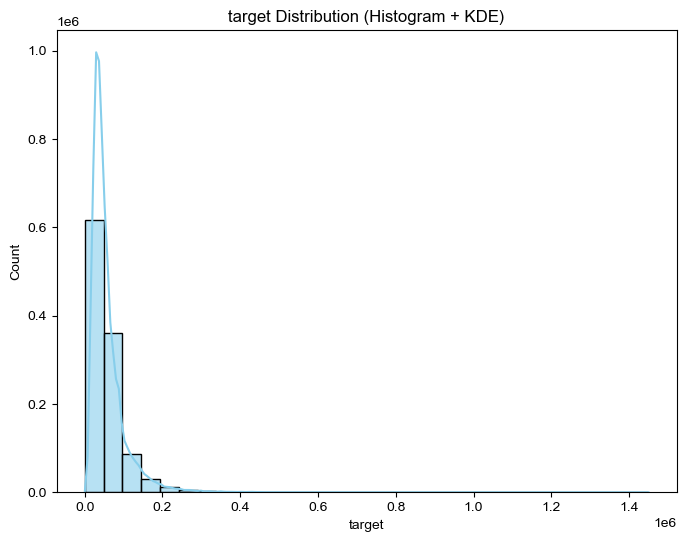

In [37]:
# 타겟변수 분포 확인
hist_plot(df1=train_df, col='target')

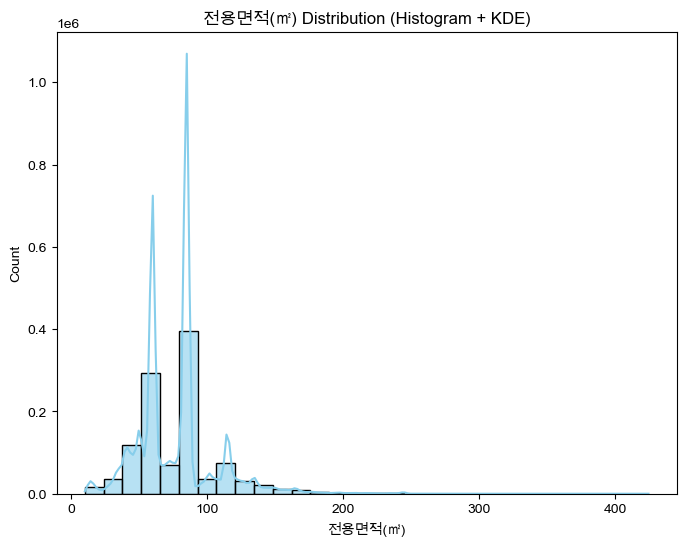

In [38]:
# 전용면적 분포 확인
hist_plot(df1=train_df, col='전용면적(㎡)')

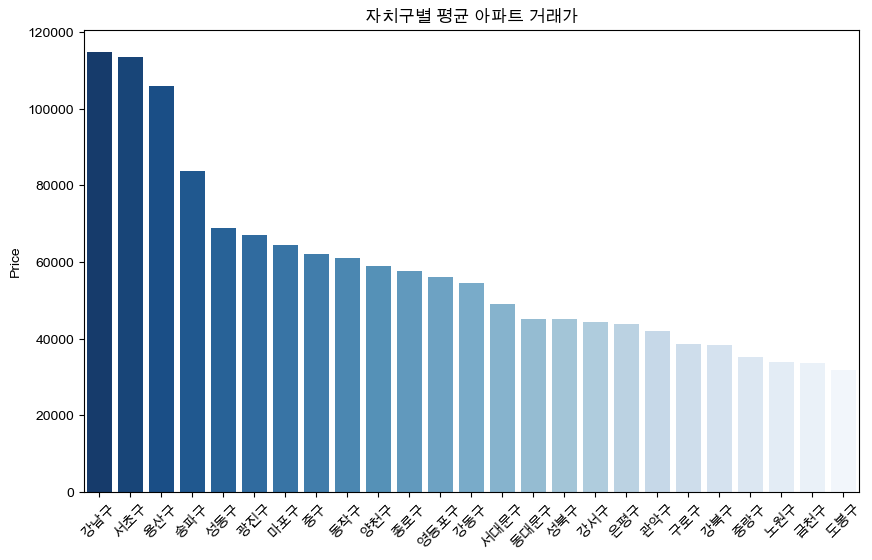

In [39]:
# 자치구 별 금액(target) 확인
group_df = train_df.groupby('구')['target'].mean().sort_values(ascending=False).reset_index()
bar_plot(df=group_df, x_col='구', y_col='target', ylabel='Price',  rotation=45, title='자치구별 평균 아파트 거래가')

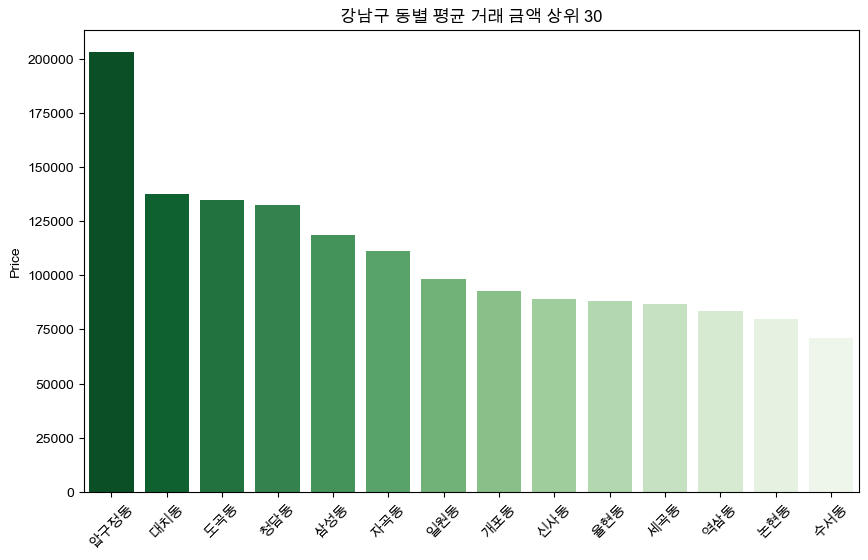

In [40]:
# 가장 비싼 강남구에 동별 금액 확인
gannam_gu = train_df[train_df['구'] == '강남구']
dong_df = gannam_gu.groupby('동')['target'].mean().sort_values(ascending=False).reset_index().head(30)
 
bar_plot(df=dong_df, x_col='동', y_col='target', ylabel='Price', rotation=45, title='강남구 동별 평균 거래 금액 상위 30', palette='Greens_r')

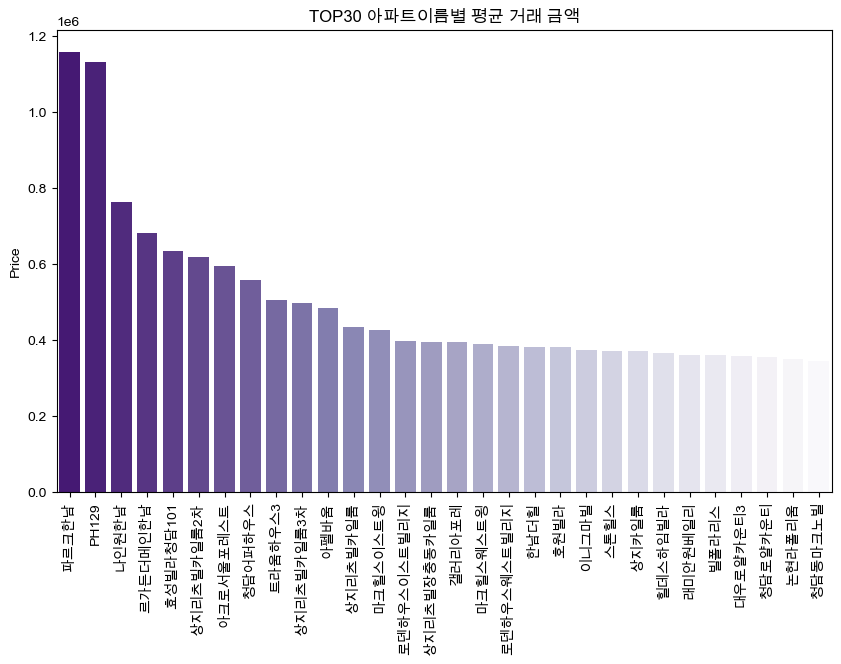

In [41]:
# 가장 비싼 강남구에 동별 금액 확인
apt_name = train_df.groupby('아파트명')['target'].mean().sort_values(ascending=False).reset_index().head(30)
bar_plot(df=apt_name, x_col='아파트명', y_col='target', ylabel='Price', rotation=90, title='TOP30 아파트이름별 평균 거래 금액', palette='Purples_r')

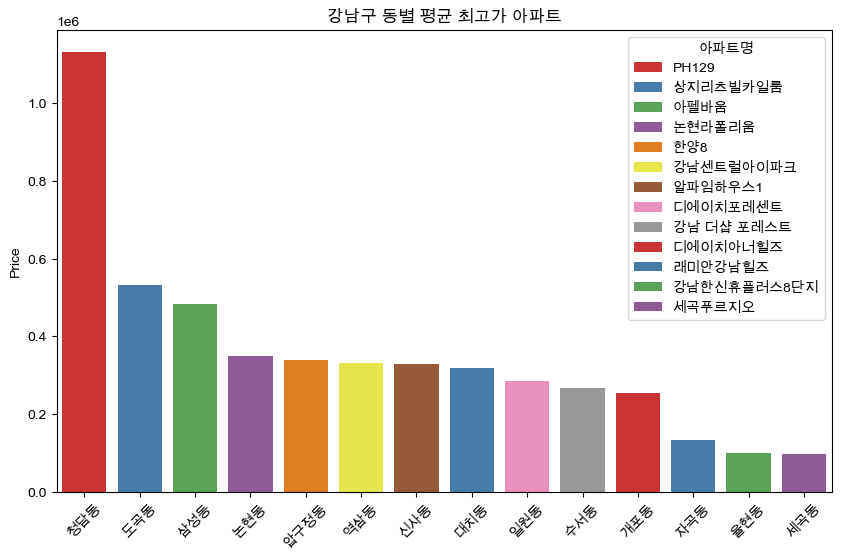

In [42]:
# 강남구 동별 최고가 아파트 확인
gangnam_df = train_df[train_df['구'] == '강남구']
dong_apt_price = gangnam_df.groupby(['동', '아파트명'])['target'].mean().reset_index()
dong_top_apt = dong_apt_price.sort_values(by=['target'], ascending=False) \
                              .groupby('동').head(1).reset_index(drop=True)

bar_plot(df=dong_top_apt, x_col='동', y_col='target', ylabel='Price', hue='아파트명', rotation=45, title='강남구 동별 평균 최고가 아파트', palette='Set1')

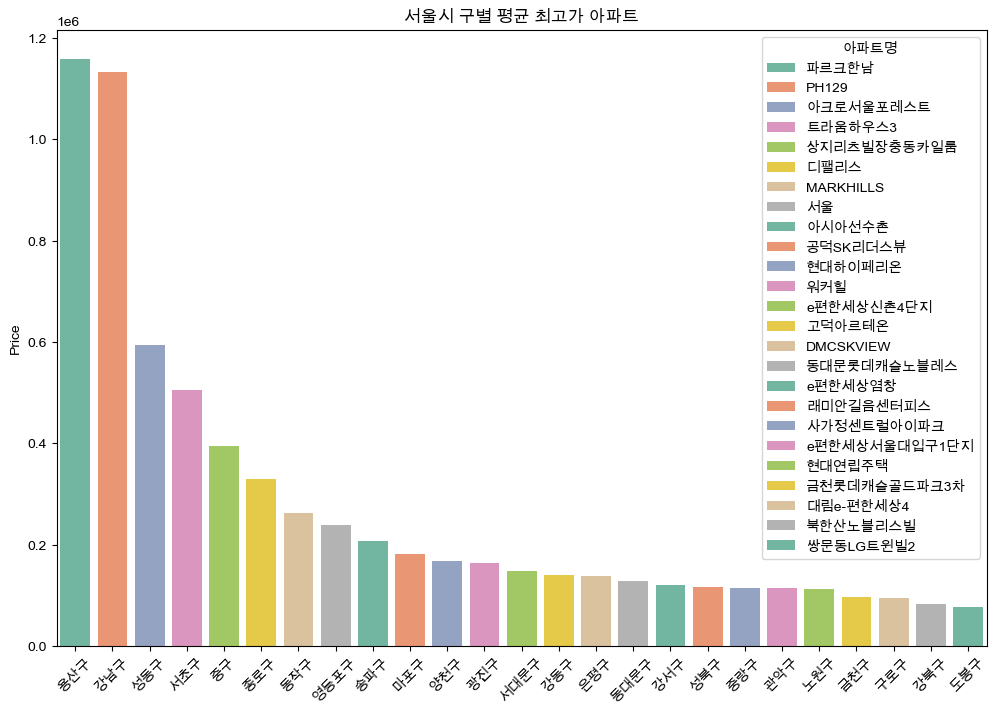

In [43]:
gu_apt_price = train_df.groupby(['구', '아파트명'])['target'].mean().reset_index()
gu_top_apt = gu_apt_price.sort_values(by='target', ascending=False) \
                         .groupby('구').head(1).reset_index(drop=True)

bar_plot(df=gu_top_apt, x_col='구', y_col='target', figsize=(12, 8), ylabel='Price', hue='아파트명', rotation=45, title='서울시 구별 평균 최고가 아파트', palette='Set2')

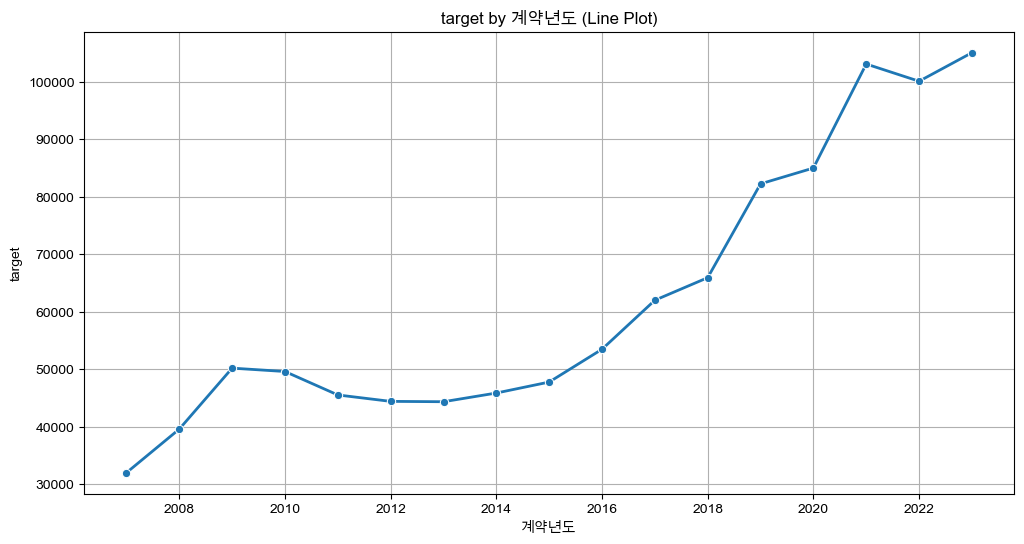

In [44]:
# 연도별 아파트 거래가 확인
train_df['계약년도']  = train_df['계약년월'] // 100
train_df['계약월'] = train_df['계약년월'] % 100

test_df['계약년도']  = test_df['계약년월'] // 100
test_df['계약월'] = test_df['계약년월'] % 100

year_df = train_df.groupby('계약년도')['target'].mean().sort_values(ascending=False).reset_index()
line_plot(df=year_df, x_col='계약년도', y_col='target')

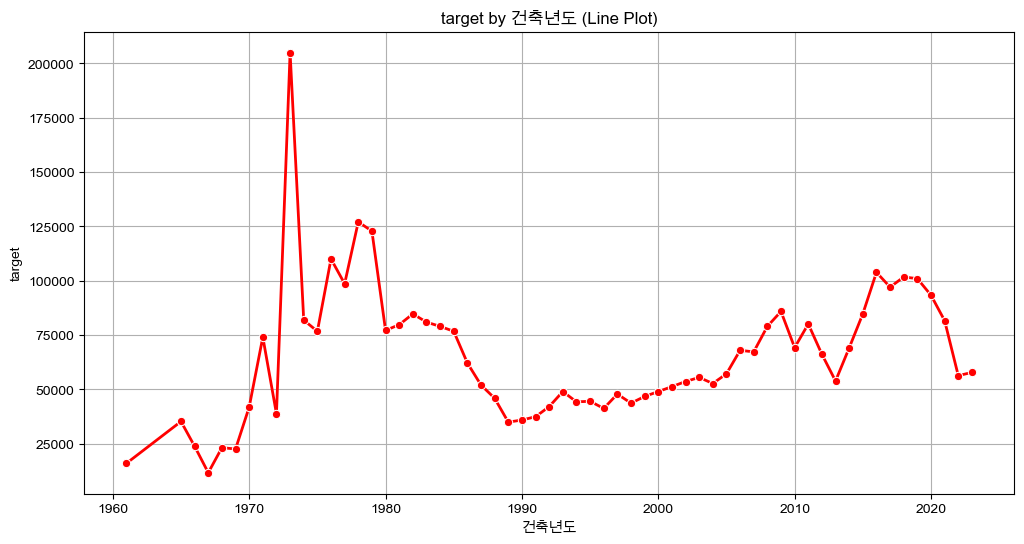

In [45]:
bild_year_df = train_df.groupby('건축년도')['target'].mean().sort_values(ascending=False).reset_index()
line_plot(df=bild_year_df, x_col='건축년도', y_col='target', color='red')

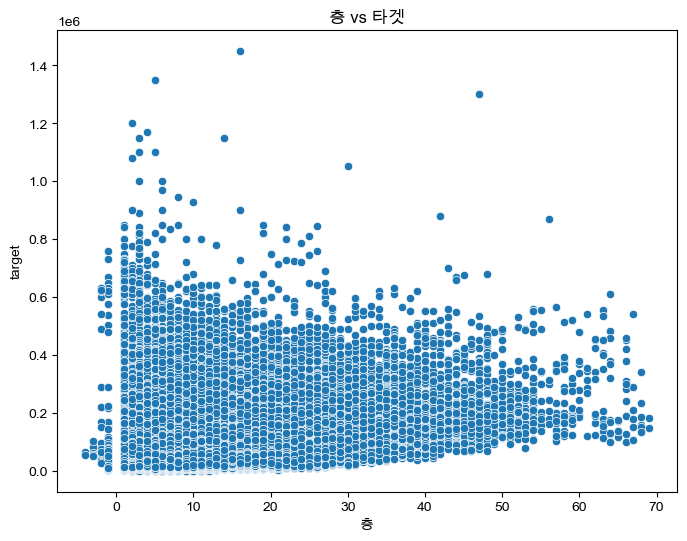

count    1.118822e+06
mean     8.871968e+00
std      5.982584e+00
min     -4.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.200000e+01
max      6.900000e+01
Name: 층, dtype: float64

In [46]:
# 층 확인
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='층', y='target')
plt.title('층 vs 타겟')
plt.show()

train_df['층'].describe()

## Feature Engineering

- Spearman Correlation
- Mutual Information Feature Selection
- Kruskal-Wallis H-test
- Encoding

In [47]:
is_train_index = train.index.equals(train_df.index)
is_test_index = test.index.equals(test_df.index)

print(f"Train 인덱스 동일 여부: {is_train_index}")
print(f"Test 인덱스 동일 여부: {is_test_index}\n")

print(f"Train 결측치: {train_df.isna().sum().sum()}")
print(f"Test 결측치: {test_df.isna().sum().sum()}")

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True

Train 결측치: 0
Test 결측치: 0


In [48]:
df_train = train_df.copy()
df_test = test_df.copy()

target = df_train['target'].copy()
df_train.drop(columns=['target'], inplace=True)

# 원본 인덱스 저장
train_orig_index = df_train.index
test_orig_index = df_test.index
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"Total Data Shape: {df.shape}")
print(f"Missing Values: {df.isna().sum().sum()}")

Total Data Shape: (1128094, 40)
Missing Values: 0


In [49]:
EARTH_RADIUS = 6371.0  # 단위: km

def geo_distance_or_count(source_df, ref_df, source_lat='위도', source_lon='경도', ref_lat='위도', ref_lon='경도', metric='haversine', mode='min', radius_km=1.0) -> np.ndarray:
    src_coords = np.radians(source_df[[source_lat, source_lon]].values)
    ref_coords = np.radians(ref_df[[ref_lat, ref_lon]].values)
    tree = BallTree(ref_coords, metric=metric)

    if mode == 'min':
        distances, _ = tree.query(src_coords, k=1)
        return distances.flatten() * EARTH_RADIUS

    elif mode == 'count':
        radius_rad = radius_km / EARTH_RADIUS
        indices = tree.query_radius(src_coords, r=radius_rad)
        return np.array([len(x) for x in indices])

    else:
        raise ValueError("mode must be either 'min' or 'count'")

In [50]:
han_rang = garden[garden['공원명'].str.endswith('한강공원')]
han_rang

,구,공원명,위도,경도
130,강동구,광나루한강공원,37.551175,127.122202
131,송파구,잠실한강공원,37.520000,127.080000
132,광진구,뚝섬한강공원,37.531000,127.066000
133,서초구,잠원한강공원,37.521870,127.012297
134,용산구,이촌한강공원,337.516920,126.971702
135,서초구,반포한강공원,37.510623,126.995963
136,마포구,망원한강공원,37.552792,126.898561
137,영등포구,여의도한강공원,37.526711,126.934711
138,마포구,난지한강공원,37.566787,126.878012
139,강서구,강서한강공원,37.586094,126.817160


In [51]:
boss_apt = [
    {"구": "강서구", "위도": 37.56520754904415, "경도": 126.82349451366355},
    {"구": "관악구", "위도": 37.47800896704934, "경도": 126.94178722423047},
    {"구": "강남구", "위도": 37.530594054209146, "경도": 127.0262701317293},
    {"구": "강동구", "위도": 37.557175745977375, "경도": 127.16359581113558},
    {"구": "광진구", "위도": 37.543083184171, "경도": 127.0998363490422},
    {"구": "구로구", "위도": 37.51045944660659, "경도": 126.88687199829572},
    {"구": "금천구", "위도": 37.459818907487936, "경도": 126.89741481874103},
    {"구": "노원구", "위도": 37.63952738902813, "경도": 127.07234254197617},
    {"구": "도봉구", "위도": 37.65775043994647, "경도": 127.04345013224447},
    {"구": "동대문구", "위도": 37.57760781415707, "경도": 127.05375628992316},
    {"구": "동작구", "위도": 37.509881249641495, "경도": 126.9618159122961},
    {"구": "마포구", "위도": 37.54341664563958, "경도": 126.93601641235335},
    {"구": "서대문구", "위도": 37.55808950436837, "경도": 126.9559315685538},
    {"구": "서초구", "위도": 37.50625410912666, "경도": 126.99846468032919},
    {"구": "성동구", "위도": 37.53870643389788, "경도": 127.04496220606433},
    {"구": "성북구", "위도": 37.61158435092128, "경도": 127.02699796439015},
    {"구": "송파구", "위도": 37.512817775046074, "경도": 127.08340371063358},
    {"구": "양천구", "위도": 37.526754982736556, "경도": 126.86618704123521},
    {"구": "영등포구", "위도": 37.52071403351804, "경도": 126.93668907644046},
    {"구": "용산구", "위도": 37.521223570097305, "경도": 126.97345317787784},
    {"구": "은평구", "위도": 37.60181702377437, "경도": 126.9362806808709},
    {"구": "종로구", "위도": 37.56856915384472, "경도": 126.96687674967252},
    {"구": "중구", "위도": 37.5544678205846, "경도": 126.9634879236162},
    {"구": "중랑구", "위도": 37.58171824083332, "경도": 127.08183326205129},]
boss_df = pd.DataFrame(boss_apt)
boss_df

,구,위도,경도
0,강서구,37.565208,126.823495
1,관악구,37.478009,126.941787
2,강남구,37.530594,127.026270
3,강동구,37.557176,127.163596
4,광진구,37.543083,127.099836
5,구로구,37.510459,126.886872
6,금천구,37.459819,126.897415
7,노원구,37.639527,127.072343
8,도봉구,37.657750,127.043450
9,동대문구,37.577608,127.053756


In [52]:
department_stores = mart[mart['사업장명'].str.contains('백화점', na=False)].reset_index(drop=True)
department_stores

,구,사업장명,검색주소,위도,경도
0,중구,신세계백화점,"서울특별시 중구 소공로 63 (충무로1가,신세계백화점건물)",37.561266,126.985364
1,중구,롯데백화점 본점,서울특별시 중구 남대문로 81 (소공동),37.568116,127.008473
2,광진구,롯데백화점 건대스타시티점,서울특별시 광진구 능동로 92 (자양동),37.536610,127.087852
3,동대문구,롯데백화점 청량리역사점,서울특별시 동대문구 왕산로 214 (전농동),37.579038,127.039143
4,동대문구,건강백화점 동의보감,서울특별시 동대문구 용두동 787번지,37.577986,127.057269
5,성북구,현대백화점 미아점,"서울특별시 성북구 동소문로 315 (길음동, 현대백화점미아점)",37.620422,127.019095
6,강북구,롯데백화점 미아점,서울특별시 강북구 도봉로 62 (미아동),37.641286,127.067907
7,노원구,롯데백화점 노원점,서울특별시 노원구 동일로 1414 (상계동),37.594224,126.917855
8,노원구,건영옴니백화점,서울특별시 노원구 중계동 506번지,37.581484,126.905098
9,노원구,롯데백화점 상계점,서울특별시 노원구 상계동 713호,37.556083,126.935845


In [53]:
bus = bus.rename(columns={'X좌표':'경도', 'Y좌표':'위도'})
hospital = hospital.rename(columns={'병원위도':'위도', '병원경도':'경도'})

bus_xy = bus[['위도', '경도']] # 정류장 위치
subway_xy = subway[['위도', '경도']]  # 역 위치
garden_xy = garden[['위도', '경도']]  # 공원 위치
han_rang_xy = han_rang[['위도', '경도']] # 한강 위치
school_xy = school[['위도', '경도']] # 학교 위치
movie_xy = movie[['위도', '경도']] # 영화관 위치
hospital_xy = hospital[['위도', '경도']] # 병원 위치
department_stores_xy = department_stores[['위도', '경도']] # 백화점 위치
mart_xy = mart[['위도', '경도']] # 마트 위치
boss_xy = boss_df[['위도', '경도']] # 대장 아파트 위치

# 버스 
df['가까운_버스_정류장(m)'] = geo_distance_or_count(df, bus_xy) * 1000  # km → m 변환
df['300m_이내_버스정류장수'] = geo_distance_or_count(df, bus_xy, radius_km=0.3, mode='count')

# 지하철 
df['가까운_지하철거리(km)'] = geo_distance_or_count(df, subway_xy) 
df['1km_이내_지하철역수'] = geo_distance_or_count(df, subway_xy, radius_km=1, mode='count')

# 공원, 한강 
df['한강_최단거리(km)'] = geo_distance_or_count(df, han_rang_xy)
df['1km_이내_한강공원수'] = geo_distance_or_count(df, han_rang_xy, radius_km=1, mode='count')
df['500m_이내_공원수'] = geo_distance_or_count(df, garden_xy, radius_km=0.5, mode='count')

# 학교 
df['가까운_학교_거리(km)'] = geo_distance_or_count(df, school_xy)
df['1km_이내_학교_수'] = geo_distance_or_count(df, school_xy, radius_km=1, mode='count')

# 영화관 
df['가까운_영화관_거리(km)'] = geo_distance_or_count(df, movie_xy)
df['1km_이내_영화관_수'] = geo_distance_or_count(df, movie_xy, radius_km=1, mode='count')

# 병원
df['가까운_병원_거리(km)'] = geo_distance_or_count(df, hospital_xy)
df['1km_이내_병원_수'] = geo_distance_or_count(df, hospital_xy, radius_km=1, mode='count')

# 백화점
df['가까운_백화점_거리(km)'] = geo_distance_or_count(df, department_stores_xy)
df['1km_이내_백화점_수'] = geo_distance_or_count(df, department_stores_xy,  radius_km=1, mode='count')

# 마트 
df['가까운_마트_거리(km)'] = geo_distance_or_count(df, mart_xy)
df['500m_이내_마트_수'] = geo_distance_or_count(df, mart_xy, radius_km=0.5, mode='count')

# 대장 아파트 
df['가까운_대장아파트거리(km)'] = geo_distance_or_count(df, boss_xy)

# 지하철 호선 추가
apt_coords = np.radians(df[['위도', '경도']].values)
subway_coords = np.radians(subway[['위도', '경도']].values)
subway_tree = BallTree(subway_coords, metric='haversine') # BallTree 생성 
distances, indices = subway_tree.query(apt_coords, k=1)  # 가장 가까운 지하철 인덱스
nearest_subway_lines = subway.iloc[indices.flatten()]['호선'].values
df['가까운_지하철_호선'] = nearest_subway_lines 

check_col = [
    "구",
    "동",
    "아파트명",
    "가까운_버스_정류장(m)",
    "300m_이내_버스정류장수",
    "가까운_지하철거리(km)",
    "1km_이내_지하철역수",
    "가까운_지하철_호선",
    "한강_최단거리(km)",
    "1km_이내_한강공원수",
    "500m_이내_공원수",
    "가까운_학교_거리(km)",
    "1km_이내_학교_수",
    "가까운_영화관_거리(km)",
    "1km_이내_영화관_수",
    "가까운_병원_거리(km)",
    "1km_이내_병원_수",
    "가까운_백화점_거리(km)",
    "1km_이내_백화점_수",
    "가까운_마트_거리(km)",
    "500m_이내_마트_수",
    "가까운_대장아파트거리(km)"]

df[check_col].head(3)

,구,동,아파트명,가까운_버스_정류장(m),300m_이내_버스정류장수,가까운_지하철거리(km),1km_이내_지하철역수,가까운_지하철_호선,한강_최단거리(km),1km_이내_한강공원수,...,1km_이내_학교_수,가까운_영화관_거리(km),1km_이내_영화관_수,가까운_병원_거리(km),1km_이내_병원_수,가까운_백화점_거리(km),1km_이내_백화점_수,가까운_마트_거리(km),500m_이내_마트_수,가까운_대장아파트거리(km)
0,강남구,개포동,개포6차우성,61.783212,7,1.129775,0,분당선,5.211185,0,...,7,1.48425,0,0.252869,65,4.991391,0,1.390216,0,4.627435
1,강남구,개포동,개포6차우성,61.783212,7,1.129775,0,분당선,5.211185,0,...,7,1.48425,0,0.252869,65,4.991391,0,1.390216,0,4.627435
2,강남구,개포동,개포6차우성,61.783212,7,1.129775,0,분당선,5.211185,0,...,7,1.48425,0,0.252869,65,4.991391,0,1.390216,0,4.627435


In [54]:
def covid_19(year):
    if year < 2020:
        return '코로나_이전'
    elif year == 2020:
        return '코로나_초기'
    elif year == 2021:
        return '코로나_과열'
    elif year == 2022:
        return '코로나_고점'
    else:
        return '코로나_진정'
    
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

In [55]:
# 파생변수 생성
df['코로나_이후'] = (df['계약년도'] >= 2020).astype(int)
df['코로나_시기'] = df['계약년도'].apply(covid_19)
df['신축여부'] = (df['건축년도'] >= 2015).astype(int) 
df['계절'] = df['계약월'].apply(get_season)
df.drop(columns=['계약년월'], inplace=True )

# 확인
df[['계약년도', '계약월', '계약일', '코로나_이후', '코로나_시기', '신축여부', '계절']].head()

,계약년도,계약월,계약일,코로나_이후,코로나_시기,신축여부,계절
0,2017,12,8,0,코로나_이전,0,겨울
1,2017,12,22,0,코로나_이전,0,겨울
2,2017,12,28,0,코로나_이전,0,겨울
3,2018,1,3,0,코로나_이전,0,겨울
4,2018,1,8,0,코로나_이전,0,겨울


In [56]:
gu_top_apt

,구,아파트명,target
0,용산구,파르크한남,1.158333e+06
1,강남구,PH129,1.132268e+06
2,성동구,아크로서울포레스트,5.948000e+05
3,서초구,트라움하우스3,5.050000e+05
4,중구,상지리츠빌장충동카일룸,3.940000e+05
5,종로구,디팰리스,3.298333e+05
6,동작구,MARKHILLS,2.626549e+05
7,영등포구,서울,2.385062e+05
8,송파구,아시아선수촌,2.062122e+05
9,마포구,공덕SK리더스뷰,1.815000e+05


In [57]:
gang_nam = ['강남구', '서초구', '송파구', '동작구', '강동구', '영등포구']
df['강남_여부'] = df['구'].apply(lambda x: 1 if x in gang_nam else 0)
df['전용면적_구간'] = pd.cut(df['전용면적(㎡)'], bins=[0, 30, 60, 85, 135, np.inf], labels=['30이하', '30~60', '60~85', '85~135', '135초과'])

apt_brand_list = [
    '래미안', '자이', '더샵', '푸르지오', '힐스테이트', 'e편한세상', '롯데캐슬',
    '아이파크', 'SK뷰', 'SK V1', '르엘', '디에이치', '써밋', '디에스타지오',
    '브라이튼', '아크로', '파크리오', '트리마제', '센트레빌', '벨리체', 'PH129']

apt_brand = '|'.join(apt_brand_list)
df['아파트_브랜드_여부'] = df['아파트명'].str.contains(apt_brand, case=False, na=False).astype(int)

# 확인
df[['구', '강남_여부', '전용면적_구간', '아파트_브랜드_여부']].head()

,구,강남_여부,전용면적_구간,아파트_브랜드_여부
0,강남구,1,60~85,0
1,강남구,1,60~85,0
2,강남구,1,30~60,0
3,강남구,1,60~85,0
4,강남구,1,60~85,0


In [58]:
price = price.rename(columns={'Year': '계약년도', 'Month': '계약월'})
final_df = pd.merge(df, crime_pop_money, on='구', how='left')
final_df = pd.merge(final_df, price, on=['구', '계약년도', '계약월'], how='left')

print(f"Train Data: {final_df.shape}")
print(f"Train Missing: {final_df.isna().sum().sum()}")

Train Data: (1128094, 93)
Train Missing: 0


In [59]:
def clean_col_names(df):
    df = df.copy()
    cleaned_columns = []

    for col in df.columns:
        cleaned = re.sub(r'[^\w]', '_', col)    # 특수문자 → 언더바
        cleaned = re.sub(r'_+', '_', cleaned)   # 연속 언더바 → 하나로
        cleaned = cleaned.strip('_')            # 양쪽 언더바 제거
        cleaned_columns.append(cleaned)

    df.columns = cleaned_columns
    return df

In [60]:
# 분리 및 인덱스 복원
final_train = final_df[final_df['label'] == 'Train'].copy()
final_train['orig_index'] = train_orig_index.to_numpy()
final_train = final_train.sort_values('orig_index').reset_index(drop=True)

final_test = final_df[final_df['label'] == 'Test'].copy()
final_test['orig_index'] = test_orig_index.to_numpy()
final_test = final_test.sort_values('orig_index').reset_index(drop=True)

# 특수문자 제거(컬럼명)
final_train = clean_col_names(final_train)
final_test = clean_col_names(final_test)

# label 제거
final_train.drop(columns=['label', 'orig_index'], inplace=True)
final_test.drop(columns=['label', 'orig_index'], inplace=True)
final_train['target'] = target # 타겟 복원

# 원본 인덱스랑 final 인덱스 동일한지 비교
is_train_index_equal = train.index.equals(final_train.index)
is_test_index_equal = test.index.equals(final_test.index)

print(f"Train 인덱스 동일 여부: {is_train_index_equal}")
print(f"Test 인덱스 동일 여부: {is_test_index_equal}\n")

print(f"Train Data: {final_train.shape}")
print(f"Test Data: {final_test.shape}\n")

print(f"Train Missing: {final_train.isna().sum().sum()}")
print(f"Test Missing: {final_test.isna().sum().sum()}")

Train 인덱스 동일 여부: True
Test 인덱스 동일 여부: True

Train Data: (1118822, 93)
Test Data: (9272, 92)

Train Missing: 0
Test Missing: 0


In [61]:
# # 저장
# final_train.to_csv("../data/Preprocessed_data/Train_preprocessed.csv", index=False)
# final_test.to_csv("../data/Preprocessed_data/Test_preprocessed.csv", index=False)

### Spearman Correlation

In [62]:
check_shapiro(final_train)

정규성 만족 Columns: 0
정규성 불만족 Columns: 69


In [63]:
def spearman_test(df, target_col):
    df_numeric = df.select_dtypes(include=['number'])
    features = []
    correlations = []
    p_values = []

    for col in df_numeric.columns:
        if col != target_col:
            corr, p = spearmanr(df_numeric[target_col], df_numeric[col])
            features.append(col)
            correlations.append(corr)
            p_values.append(p)

    corr_df = pd.DataFrame({
        'Feature': features,
        'Correlation': correlations,
        'P-value': p_values}).sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return corr_df

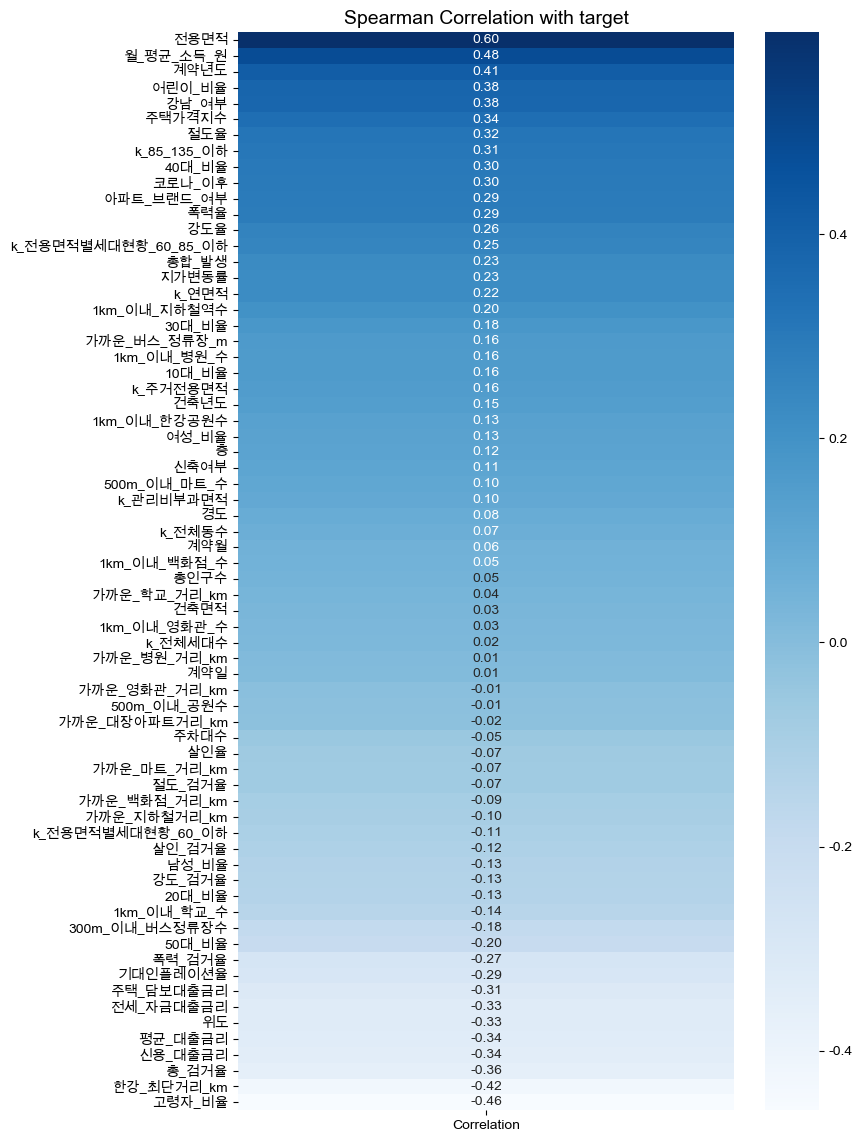

,Feature,Correlation,P-value
0,전용면적,0.597664,0.0
1,월_평균_소득_원,0.484656,0.0
2,계약년도,0.414170,0.0
3,어린이_비율,0.380330,0.0
4,강남_여부,0.376746,0.0
...,...,...,...
63,평균_대출금리,-0.337738,0.0
64,신용_대출금리,-0.344268,0.0
65,총_검거율,-0.362811,0.0
66,한강_최단거리_km,-0.422960,0.0


In [64]:
spearman_df = spearman_test(final_train, target_col='target')
heat_map(df=final_train, target_col='target', figsize=(8, 14), method='spearman', cmap='Blues') # 타겟 변수와 상관계수
spearman_df

In [65]:
# 유의성 확인
p_val_col = spearman_df[spearman_df['P-value'] >= 0.05]
p_val_col

,Feature,Correlation,P-value


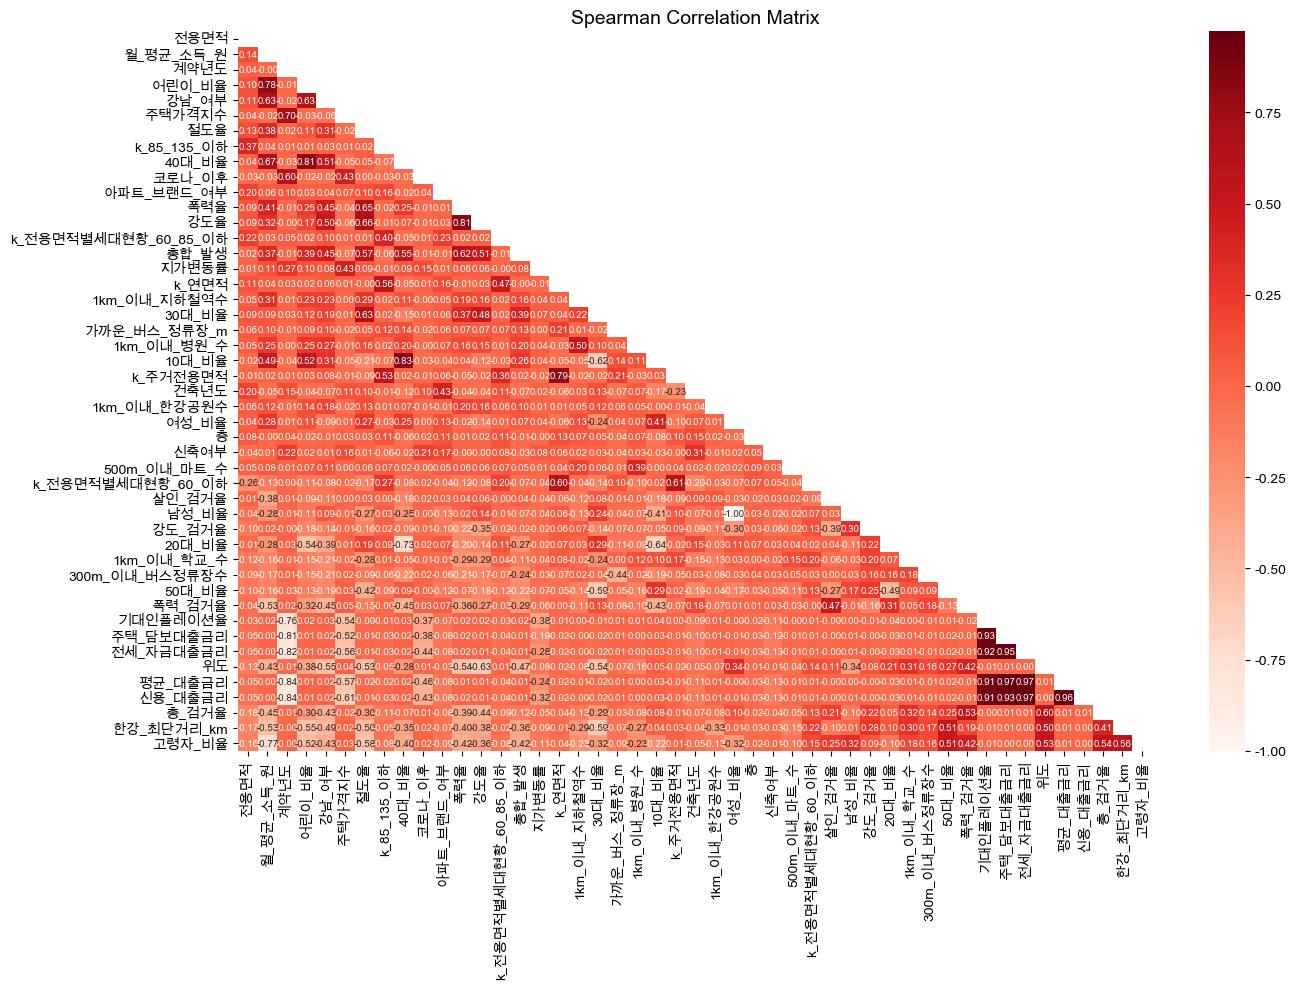

In [66]:
# target과 상관계수가 0.1 이상인 변수 필터
cprr_cols = spearman_df[spearman_df['Correlation'].abs() >= 0.1]['Feature'].tolist()
corr = final_train[cprr_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool)) # 마스크 생성 (상삼각행렬 제외)

plt.figure(figsize=(14, 10))
sns.heatmap(corr, mask=mask, cmap='Reds', annot=True, fmt='.2f', annot_kws={'size': 7}, cbar=True)
plt.title('Spearman Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

In [67]:
def remove_high_corr_target(df, target_col, threshold=0.95, method='spearman'):
    feats = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    corr_feats = df[feats].corr(method=method).abs()
    corr_target = df[feats].corrwith(df[target_col], method=method).abs()
    
    to_drop = set()
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            # 0.95 초과인 경우
            if corr_feats.loc[f1, f2] > threshold:
                if corr_target[f1] >= corr_target[f2]:
                    to_drop.add(f2)
                else:
                    to_drop.add(f1)
    return list(to_drop)

In [68]:
corr_drop_cols = remove_high_corr_target(final_train, target_col='target', threshold=0.95, method='spearman')
print("제거할 피처 수:", len(corr_drop_cols))
print("제거할 피처:", corr_drop_cols)

제거할 피처 수: 4
제거할 피처: ['여성_비율', '전세_자금대출금리', '평균_대출금리', '주택_담보대출금리']


### Mutual Information Feature Selection

In [69]:
# 비모수 검정
X = final_train.select_dtypes(include=['number']).drop(columns=['target'])
y = final_train['target']

mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False).reset_index(drop=True)
mi_df

,Feature,mi_score
0,k_연면적,0.652908
1,k_주거전용면적,0.647961
2,한강_최단거리_km,0.637555
3,위도,0.637388
4,경도,0.633948
...,...,...
63,계약월,0.011573
64,1km_이내_한강공원수,0.010123
65,1km_이내_백화점_수,0.005816
66,500m_이내_공원수,0.004857


In [70]:
low_spearman = (spearman_df[spearman_df['Correlation'].between(-0.1, 0.1)]['Feature'].tolist()) # -0.1 ≤ Corr ≤ 0.1
low_mi = (mi_df[mi_df['mi_score'] <= 0.1]['Feature'].tolist()) # MI 스코어 ≤ 0.1 인 피처 리스트

to_remove_mi = list(set(low_spearman) & set(low_mi)) # 모두 포함(교집합)
print("제거할 피처 수:", len(to_remove_mi))
print("제거할 피처:", to_remove_mi)

제거할 피처 수: 5
제거할 피처: ['계약일', '500m_이내_공원수', '1km_이내_영화관_수', '계약월', '1km_이내_백화점_수']


In [71]:
to_remove_mi = ['1km_이내_영화관_수', '1km_이내_백화점_수', '500m_이내_공원수', '계약일']
final_train = final_train.drop(columns=to_remove_mi)
final_test = final_test.drop(columns=to_remove_mi)

print(f"Train Data: {final_train.shape}")
print(f"Test Data: {final_test.shape}")

Train Data: (1118822, 89)
Test Data: (9272, 88)


### Kruskal-Wallis H-test

In [72]:
# mode check
def check_mode(df):
    df = df.select_dtypes(include=['object']).copy()
    result = []

    for col in df.columns:
        mode_val = df[col].mode()[0] # 최빈값
        mode_ratio = round((df[col] == mode_val).sum() / len(df) * 100, 4)
        unique_cnt = int(df[col].nunique())

        result.append({
            'Columns': col,
            'mode': mode_val,
            'ratio(%)': mode_ratio,
            'Unique_Count': unique_cnt})
    
    result_df = pd.DataFrame(result)
    result_df['Unique_Count'] = result_df['Unique_Count'].astype(int) 
    return result_df.sort_values(by=['Unique_Count'], ascending=False).reset_index(drop=True)

# kruskal 검정
def kruskal_test(df, target_col, min_group_size=5):
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    results = []

    for col in cat_cols:
        grouped = df.groupby(col)[target_col]
        valid_groups = [grp.values for _, grp in grouped if grp.size >= min_group_size]
        if len(valid_groups) >= 2:
            stat, p = kruskal(*valid_groups)
            results.append({'feature': col, 'H-statistic': stat, 'p-value': p})

    return pd.DataFrame(results).sort_values('p-value').reset_index(drop=True)

In [73]:
check_mode(final_train)

,Columns,mode,ratio(%),Unique_Count
0,도로명,올림픽로 435,0.3863,9232
1,번지,13,0.4137,6572
2,아파트명,현대,1.4876,6539
3,중개사소재지,기타,97.3864,643
4,k_시행사,모름,77.8815,555
5,k_건설사_시공사,미확인,77.8549,345
6,동,상계동,4.0174,337
7,구,노원구,10.2875,25
8,가까운_지하철_호선,5호선,15.2494,24
9,k_단지분류_아파트_주상복합등등,기타,77.8221,6


In [74]:
kruskal_df = kruskal_test(final_train, 'target')
kruskal_df

,feature,H-statistic,p-value
0,구,348881.893947,0.0
1,코로나_시기,103058.974605,0.0
2,가까운_지하철_호선,156033.022707,0.0
3,관리비_업로드,1761.340360,0.0
4,사용허가여부,22986.052294,0.0
5,기타_의무_임대_임의_1_2_3_4,21397.159229,0.0
6,청소비관리형태,23947.017491,0.0
7,세대전기계약방법,39188.958227,0.0
8,경비비관리형태,24370.751209,0.0
9,k_시행사,162442.429286,0.0


In [75]:
# 유의성 확인
kruskal_df[kruskal_df['p-value'] >= 0.05]

,feature,H-statistic,p-value


### eta squared

In [76]:
def eta_squared_all(df, target_col):
    cat_cols = df.select_dtypes(include=['object']).columns
    grand_mean = df[target_col].mean()
    ss_total = ((df[target_col] - grand_mean) ** 2).sum()
    results = []
    for col in cat_cols:
        grp = df.groupby(col)[target_col]
        ss_between = (grp.size() * (grp.mean() - grand_mean) ** 2).sum()
        eta2 = ss_between / ss_total if ss_total > 0 else 0
        results.append({'feature': col, 'eta_squared': eta2})
    return (pd.DataFrame(results)
              .sort_values('eta_squared', ascending=False)
              .reset_index(drop=True))

eta2_df = eta_squared_all(final_train, 'target')
eta2_df

,feature,eta_squared
0,도로명,0.695392
1,아파트명,0.629977
2,번지,0.482524
3,동,0.415386
4,구,0.292703
5,k_시행사,0.194689
6,가까운_지하철_호선,0.122453
7,k_건설사_시공사,0.118070
8,코로나_시기,0.099841
9,중개사소재지,0.062540


In [77]:
mode_df = check_mode(final_train)
mode_df = mode_df.rename(columns={'Columns':'feature'})
eta2_dfs = pd.merge(eta2_df, mode_df, on='feature', how='left').sort_values(by=['Unique_Count'], ascending=False).reset_index(drop=True)
eta2_dfs

,feature,eta_squared,mode,ratio(%),Unique_Count
0,도로명,0.695392,올림픽로 435,0.3863,9232
1,번지,0.482524,13,0.4137,6572
2,아파트명,0.629977,현대,1.4876,6539
3,중개사소재지,0.062540,기타,97.3864,643
4,k_시행사,0.194689,모름,77.8815,555
5,k_건설사_시공사,0.118070,미확인,77.8549,345
6,동,0.415386,상계동,4.0174,337
7,구,0.292703,노원구,10.2875,25
8,가까운_지하철_호선,0.122453,5호선,15.2494,24
9,k_단지분류_아파트_주상복합등등,0.015180,기타,77.8221,6


In [78]:
str_features = final_train.select_dtypes(include=['object'])
test_str_feature = final_test.select_dtypes(include=['object'])

print(f"Train Object Type Data: {str_features.shape}")
print(f"Test Object Type Data: {test_str_feature.shape}")

Train Object Type Data: (1118822, 23)
Test Object Type Data: (9272, 23)


### Encoding

In [79]:
exclude_cols = ['도로명', '번지', '아파트명', '중개사소재지', 'k_시행사', 'k_건설사_시공사']  # 제외 컬럼
filtered_str_features = str_features.drop(columns=exclude_cols)
filtered_test_str_features = test_str_feature.drop(columns=exclude_cols)

label_cols = [col for col in filtered_str_features.columns if filtered_str_features[col].nunique() <= 10]
freq_cols = [col for col in filtered_str_features.columns if col not in label_cols]

# DataFrame
train_le = pd.DataFrame(index=final_train.index)
test_le = pd.DataFrame(index=final_test.index)
train_fe = pd.DataFrame(index=final_train.index)
test_fe = pd.DataFrame(index=final_test.index)

# Label Encoding - train만 fit
for col in label_cols:
    le = LabelEncoder()
    le.fit(filtered_str_features[col])  
    train_le[col + '_LE'] = le.transform(filtered_str_features[col])
    
    # 테스트 데이터 처리 (unseen 값은 -1로 처리)
    test_le[col + '_LE'] = filtered_test_str_features[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Frequency Encoding - train 기준
for col in freq_cols:
    freq = filtered_str_features[col].value_counts(normalize=True)
    train_fe[col + '_FE'] = filtered_str_features[col].map(freq)
    test_fe[col + '_FE'] = filtered_test_str_features[col].map(freq).fillna(0)

# 인코딩 결과
train_encoded = pd.concat([train_le, train_fe], axis=1)
test_encoded = pd.concat([test_le, test_fe], axis=1)

print(f"Train Object Encoding Data: {train_encoded.shape}")
print(f"Test Object Encoding Data: {test_encoded.shape}")

Train Object Encoding Data: (1118822, 17)
Test Object Encoding Data: (9272, 17)


In [80]:
num_train_data = final_train.select_dtypes(include=['number'])
num_test_data = final_test.select_dtypes(include=['number'])

# 인덱스 비교 확인 (True면 안전)
print((num_train_data.index == train_encoded.index).all())
print((num_test_data.index == test_encoded.index).all())

True
True


In [81]:
df_train = pd.concat([num_train_data, train_encoded], axis=1)
df_test = pd.concat([num_test_data, test_encoded], axis=1)

is_train_index_equal = (df_train.index == final_train.index).all()
is_test_index_equal = (df_test.index == final_test.index).all()

print(f"Index 동일 여부: {is_train_index_equal}")
print(f"Index 동일 여부: {is_test_index_equal}")

print(f"Final Train Data: {df_train.shape}")
print(f"Final Test Data: {df_test.shape}\n")

print(f"Train Data Total Missing: {df_train.isna().sum().sum()}")
print(f"Test Data Total Missing: {df_test.isna().sum().sum()}")

Index 동일 여부: True
Index 동일 여부: True
Final Train Data: (1118822, 82)
Final Test Data: (9272, 81)

Train Data Total Missing: 0
Test Data Total Missing: 0


In [82]:
# df_train.to_csv("../data/Model_data/Train_data-V1.csv", index=False)
# df_test.to_csv("../data/Model_data/Test_data-V1.csv", index=False)

## Models

- Models Selection
- Hyperparameter Tuning (Bayesian Optimization)
- Ensemble

In [83]:
# 시계열 분리
train_df = df_train[df_train['계약년도'] * 100 + df_train['계약월'] < 202305]
val_df   = df_train[df_train['계약년도'] * 100 + df_train['계약월'] >= 202305]
features = [col for col in df_train.columns if col not in ['target', '계약월']]

X_train = train_df[features]
y_train = train_df['target']
X_val   = val_df[features]
y_val   = val_df['target']

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (1111455, 80)
X_val: (7367, 80)
y_train: (1111455,)
y_val: (7367,)


### Models Selection

In [84]:
def select_models(X_train, X_val, y_train, y_val):
    models = {
    "LightGBM": LGBMRegressor(
        n_estimators=1000, 
        learning_rate=0.05, 
        max_depth=10, 
        subsample=0.8, 
        colsample_bytree=0.8,
        random_state=42, 
        n_jobs=-1, 
        verbose=-1
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=3,
        bagging_temperature=1,
        random_strength=1,
        thread_count=-1,
        random_state=42,
        verbose=False
    )
}

    results = []
    trained_models = {}
    total = len(models)

    for idx, (name, model) in enumerate(models.items(), start=1):
        print(f"[{idx}/{total}] Training model: {name} ...")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        results.append({
            "model": name,
            "RMSE": rmse,
            "MSE": mse,
            "MAE": mae,
            "R2": r2})

        trained_models[name] = model  # 모델 저장

    metrics_df = pd.DataFrame(results)
    metrics_df = metrics_df.sort_values("RMSE", ascending=True).reset_index(drop=True)

    return metrics_df, trained_models

In [85]:
metrics_df, models = select_models(X_train, X_val, y_train, y_val)
metrics_df

[1/5] Training model: LightGBM ...
[2/5] Training model: RandomForest ...
[3/5] Training model: ExtraTrees ...
[4/5] Training model: XGBoost ...
[5/5] Training model: CatBoost ...


,model,RMSE,MSE,MAE,R2
0,XGBoost,13450.242916,1.809090e+08,6900.000463,0.967388
1,CatBoost,14428.899844,2.081932e+08,7963.148518,0.962469
2,LightGBM,16351.380853,2.673677e+08,9393.835591,0.951802
3,RandomForest,20515.700302,4.208940e+08,11412.614359,0.924125
4,ExtraTrees,27301.555027,7.453749e+08,15762.725499,0.865631


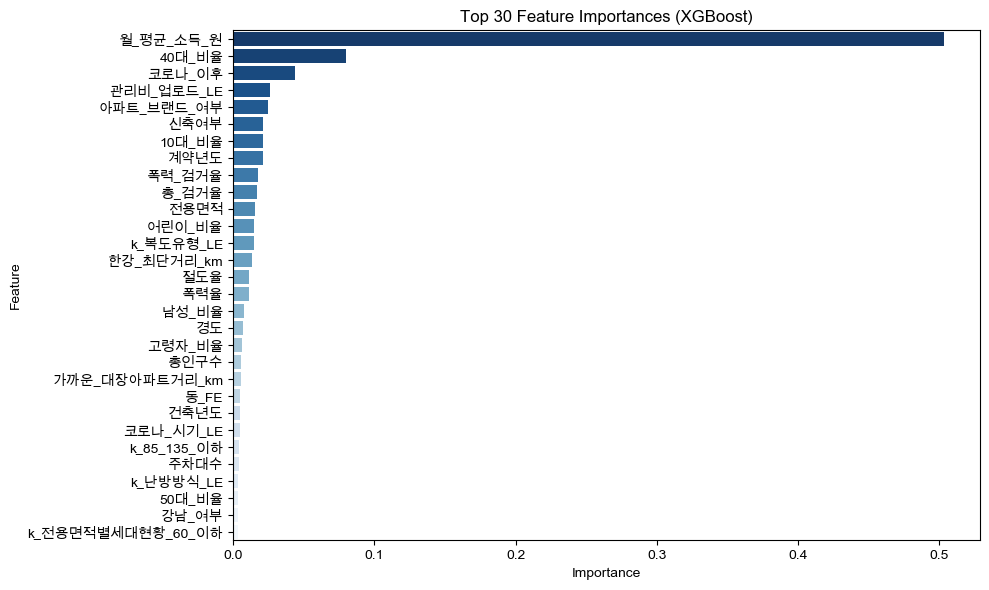


Bottom 10 Features for XGBoost


,feature,importance
70,거래유형_LE,0.000746
71,강도율,0.000727
72,전세_자금대출금리,0.000663
73,주택_담보대출금리,0.000562
74,평균_대출금리,0.000561
75,신용_대출금리,0.000536
76,청소비관리형태_LE,0.000493
77,층,0.000379
78,지가변동률,0.000249
79,계절_LE,0.000217


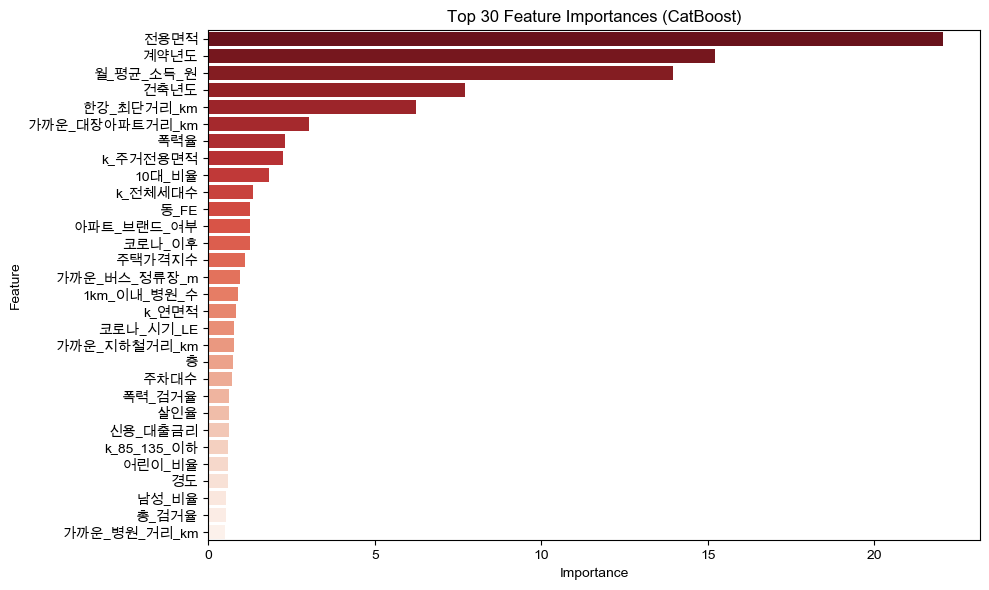


Bottom 10 Features for CatBoost


,feature,importance
70,k_관리방식_LE,0.013281
71,기타_의무_임대_임의_1_2_3_4_LE,0.012981
72,k_세대타입_분양형태_LE,0.008432
73,세대전기계약방법_LE,0.007935
74,강도_검거율,0.007784
75,사용허가여부_LE,0.007709
76,k_난방방식_LE,0.006156
77,1km_이내_한강공원수,0.005301
78,청소비관리형태_LE,0.003429
79,경비비관리형태_LE,0.002616


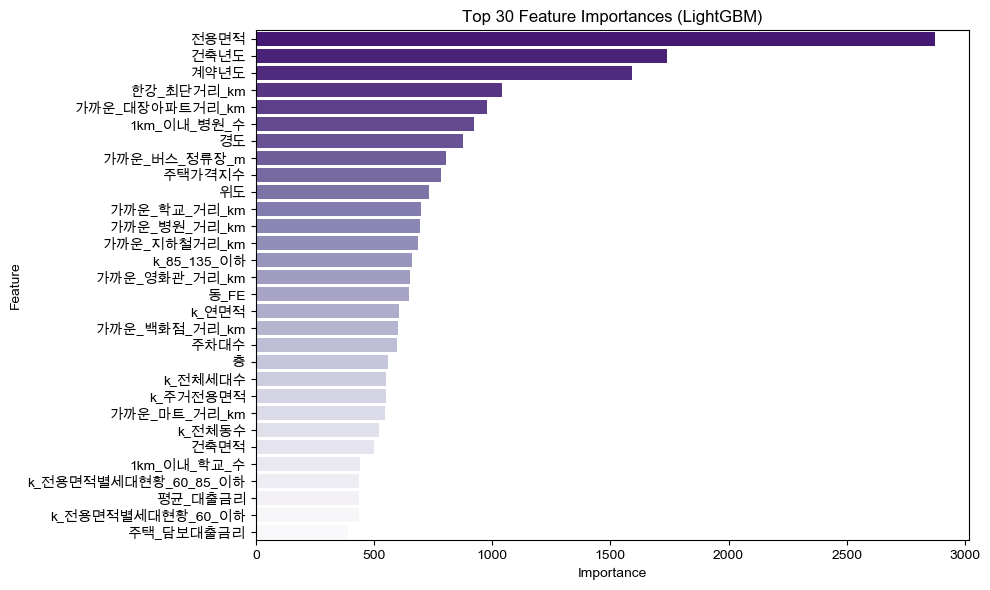


Bottom 10 Features for LightGBM


,feature,importance
70,세대전기계약방법_LE,35
71,신축여부,32
72,경비비관리형태_LE,17
73,k_관리방식_LE,13
74,k_세대타입_분양형태_LE,13
75,기타_의무_임대_임의_1_2_3_4_LE,11
76,강남_여부,10
77,청소비관리형태_LE,7
78,1km_이내_한강공원수,6
79,사용허가여부_LE,0



공통 하위 10개 feature 수: 1
공통 feature 목록: ['청소비관리형태_LE']


In [91]:
# 상위 3개 모델만 추출
top3_models = ['XGBoost', 'CatBoost', 'LightGBM']

# 시각화 색상 매핑
model_palette = {
    'XGBoost': 'Blues_r',
    'CatBoost': 'Reds_r',
    'LightGBM': 'Purples_r'}

feature_dfs = {}
bottom_features = {}

# 상위 3개 모델만 반복
for model_name in top3_models:
    model = models[model_name]
    importance = model.feature_importances_
    features = X_train.columns
    df = pd.DataFrame({'feature': features, 'importance': importance})
    df = df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_dfs[model_name] = df
    bottom_features[model_name] = set(df.tail(10)['feature'])

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df.head(30), x='importance', y='feature', palette=model_palette.get(model_name, 'gray'))
    plt.title(f'Top 30 Feature Importances ({model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # 하위 10개 출력
    print(f"\nBottom 10 Features for {model_name}")
    display(df.tail(10))  # Jupyter 환경 기준

# 공통 하위 10개 피처 교집합
bottom_common = set.intersection(*bottom_features.values())
print(f"\n공통 하위 10개 feature 수: {len(bottom_common)}")
print("공통 feature 목록:", list(bottom_common))

In [92]:
# 상위 3개 모델별 feature_importances_ 결과를 토대로 공통 하위10개 feature 제거 후 테스트
X_train_copy = X_train.drop(columns=bottom_common).copy()
X_val_copy = X_val.drop(columns=bottom_common).copy()

metrics_df, models = select_models(X_train_copy, X_val_copy, y_train, y_val) 
metrics_df

[1/5] Training model: LightGBM ...
[2/5] Training model: RandomForest ...
[3/5] Training model: ExtraTrees ...
[4/5] Training model: XGBoost ...
[5/5] Training model: CatBoost ...


,model,RMSE,MSE,MAE,R2
0,XGBoost,13382.198857,1.790832e+08,6867.697533,0.967717
1,CatBoost,14151.836530,2.002745e+08,7872.625844,0.963897
2,LightGBM,16066.978973,2.581478e+08,9327.757464,0.953464
3,RandomForest,20366.798606,4.148065e+08,11299.689212,0.925223
4,ExtraTrees,27462.055354,7.541645e+08,15806.342631,0.864047


### Hyperparameter Tuning (Bayesian Optimization)

In [93]:
def optimize_models_holdout(X_train, y_train, X_val, y_val, n_trials=20):
    def objective_xgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 2200),
            'max_depth': trial.suggest_int('max_depth', 4, 18),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.25),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
            'n_jobs': -1,
            'verbosity': 0}
        
        model = XGBRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        return mean_squared_error(y_val, preds, squared=False)

    def objective_cat(trial):
        params = {
            'depth': trial.suggest_int('depth', 4, 16),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
            'iterations': trial.suggest_int('iterations', 400, 2200),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 10.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.5),
            'random_strength': trial.suggest_float('random_strength', 0.1, 1.5),
            'thread_count': -1,
            'verbose': False}
        
        model = CatBoostRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        return mean_squared_error(y_val, preds, squared=False)

    def objective_lgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 2200),
            'max_depth': trial.suggest_int('max_depth', 4, 18),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.25),
            'num_leaves': trial.suggest_int('num_leaves', 20, 512),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
            'n_jobs': -1,
            'verbosity': -1}

        model = LGBMRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        return mean_squared_error(y_val, preds, squared=False)

    models = {
        "XGBoost": (objective_xgb, XGBRegressor),
        "CatBoost": (objective_cat, CatBoostRegressor),
        "LightGBM": (objective_lgb, LGBMRegressor)}

    results = []
    best_models = {}
    sampler = optuna.samplers.TPESampler()

    for idx, (name, (objective, cls)) in enumerate(models.items(), 1):
        print(f"[{idx}/{len(models)}] Tuning model: {name} ...")
        study = optuna.create_study(direction='minimize', sampler=sampler)
        study.optimize(objective, n_trials=n_trials)

        best_params = study.best_params

        # 공통 출력 제거 옵션 처리
        best_params['verbose'] = 0
        print(f"Best params for {name}: {best_params}")

        final_model = cls(**best_params, random_state=42)
        final_model.fit(X_train, y_train)
        preds = final_model.predict(X_val)

        results.append({
            "model": name,
            "RMSE (Val)": mean_squared_error(y_val, preds, squared=False),
            "MAE": mean_absolute_error(y_val, preds),
            "R2": r2_score(y_val, preds),
            "Best Params": best_params
        })
        best_models[name] = final_model

    result_df = pd.DataFrame(results).sort_values(by="RMSE (Val)").reset_index(drop=True)
    return result_df, best_models

In [96]:
# 시계열 분리
train_df = df_train[df_train['계약년도'] * 100 + df_train['계약월'] < 202305]
val_df   = df_train[df_train['계약년도'] * 100 + df_train['계약월'] >= 202305]
features = [col for col in df_train.columns if col not in ['target', '계약월']]

X_train = train_df[features].drop(columns=bottom_common)
y_train = train_df['target']
X_val   = val_df[features].drop(columns=bottom_common)
y_val   = val_df['target']

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (1111455, 79)
X_val: (7367, 79)
y_train: (1111455,)
y_val: (7367,)


In [98]:
result_df, best_models = optimize_models_holdout(X_train, y_train, X_val, y_val, n_trials=30)
result_df

[I 2025-05-16 14:58:41,432] A new study created in memory with name: no-name-c0afd4bd-c5c8-4713-b0d0-edcfcfe0faf5


[1/3] Tuning model: XGBoost ...


[I 2025-05-16 14:59:03,372] Trial 0 finished with value: 14359.022951413139 and parameters: {'n_estimators': 916, 'max_depth': 6, 'learning_rate': 0.10166919300653048, 'subsample': 0.7331411697282322, 'colsample_bytree': 0.5183078051317273, 'reg_alpha': 0.9609480657604739, 'reg_lambda': 0.2998713766368466}. Best is trial 0 with value: 14359.022951413139.
[I 2025-05-16 15:01:53,998] Trial 1 finished with value: 15402.460804354456 and parameters: {'n_estimators': 1662, 'max_depth': 16, 'learning_rate': 0.23321394953998478, 'subsample': 0.5073151888242873, 'colsample_bytree': 0.6754408951863389, 'reg_alpha': 1.8007087221256652, 'reg_lambda': 1.8555420246786807}. Best is trial 0 with value: 14359.022951413139.
[I 2025-05-16 15:02:35,268] Trial 2 finished with value: 13392.822469416416 and parameters: {'n_estimators': 1174, 'max_depth': 9, 'learning_rate': 0.14312497096366047, 'subsample': 0.6859434236622433, 'colsample_bytree': 0.5400515665183712, 'reg_alpha': 0.685565990832169, 'reg_lambd

Best params for XGBoost: {'n_estimators': 1849, 'max_depth': 8, 'learning_rate': 0.07989306848814991, 'subsample': 0.8164018778208346, 'colsample_bytree': 0.8079558795957749, 'reg_alpha': 0.2555996216873856, 'reg_lambda': 1.9898034764686392, 'verbose': 0}


[I 2025-05-16 15:37:32,703] A new study created in memory with name: no-name-ddc91f21-3abb-45c9-96bd-7abed5e00abb


[2/3] Tuning model: CatBoost ...


[I 2025-05-16 15:40:20,984] Trial 0 finished with value: 13612.992410753732 and parameters: {'depth': 11, 'learning_rate': 0.16882090191366114, 'iterations': 490, 'l2_leaf_reg': 5.217310734295247, 'bagging_temperature': 0.5711139608793213, 'random_strength': 0.5936496153682472}. Best is trial 0 with value: 13612.992410753732.
[I 2025-05-16 15:41:36,170] Trial 1 finished with value: 20651.635367379327 and parameters: {'depth': 4, 'learning_rate': 0.04569955684454425, 'iterations': 1334, 'l2_leaf_reg': 2.0280096999930484, 'bagging_temperature': 0.5169111267999512, 'random_strength': 1.05393261703367}. Best is trial 0 with value: 13612.992410753732.
[I 2025-05-16 16:07:04,231] Trial 2 finished with value: 14223.410617414409 and parameters: {'depth': 15, 'learning_rate': 0.18789034809000188, 'iterations': 1758, 'l2_leaf_reg': 6.1272121514982345, 'bagging_temperature': 1.284561846220434, 'random_strength': 1.4421460877351822}. Best is trial 0 with value: 13612.992410753732.
[I 2025-05-16 16

Best params for CatBoost: {'depth': 9, 'learning_rate': 0.19639649581309382, 'iterations': 2021, 'l2_leaf_reg': 8.376079966790892, 'bagging_temperature': 0.9076962320885474, 'random_strength': 0.9129453289183087, 'verbose': 0}


[I 2025-05-16 18:59:22,009] A new study created in memory with name: no-name-d633f46d-2770-409f-b83a-1e61c8124157


[3/3] Tuning model: LightGBM ...


[I 2025-05-16 18:59:48,267] Trial 0 finished with value: 13405.729402742352 and parameters: {'n_estimators': 461, 'max_depth': 10, 'learning_rate': 0.10358998471448723, 'num_leaves': 401, 'subsample': 0.8699279830245947, 'colsample_bytree': 0.9610283855262642, 'reg_alpha': 1.9014070322316847, 'reg_lambda': 0.64939501415829}. Best is trial 0 with value: 13405.729402742352.
[I 2025-05-16 19:00:20,830] Trial 1 finished with value: 13848.19173241447 and parameters: {'n_estimators': 1806, 'max_depth': 18, 'learning_rate': 0.2211816645796211, 'num_leaves': 29, 'subsample': 0.9439250096719025, 'colsample_bytree': 0.6859746229559114, 'reg_alpha': 1.917305104700276, 'reg_lambda': 0.053907847489501615}. Best is trial 0 with value: 13405.729402742352.
[I 2025-05-16 19:00:49,230] Trial 2 finished with value: 14600.070459919649 and parameters: {'n_estimators': 630, 'max_depth': 12, 'learning_rate': 0.038634262376338754, 'num_leaves': 175, 'subsample': 0.6852067340840354, 'colsample_bytree': 0.55614

Best params for LightGBM: {'n_estimators': 2195, 'max_depth': 12, 'learning_rate': 0.09589220084837626, 'num_leaves': 227, 'subsample': 0.7321425114129531, 'colsample_bytree': 0.9798518095989488, 'reg_alpha': 1.5754752752319452, 'reg_lambda': 1.6916968460035948, 'verbose': 0}
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

,model,RMSE (Val),MAE,R2,Best Params
0,CatBoost,12546.681810,6878.978420,0.971622,"{'depth': 9, 'learning_rate': 0.19639649581309..."
1,LightGBM,12815.422845,6641.002936,0.970393,"{'n_estimators': 2195, 'max_depth': 12, 'learn..."
2,XGBoost,12905.658812,6796.717837,0.969975,"{'n_estimators': 1849, 'max_depth': 8, 'learni..."


### Ensemble

In [99]:
voting_model = VotingRegressor(estimators=[
    ('xgb', best_models['XGBoost']),
    ('cat', best_models['CatBoost']),
    ('lgb', best_models['LightGBM'])])

# 시계열 validation 기준 학습
voting_model.fit(X_train, y_train)
val_preds = voting_model.predict(X_val)

# 평가
rmse = mean_squared_error(y_val, val_preds, squared=False)
mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print(f"VotingRegressor on Validation Set")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [100]:
voting_weighted_model = VotingRegressor(
    estimators=[
        ('xgb', best_models['XGBoost']),
        ('cat', best_models['CatBoost']),
        ('lgb', best_models['LightGBM'])],
    weights=[0.3, 0.4, 0.3])  # CatBoost에 더 높은 가중치 부여

# 시계열 validation 기준 학습
voting_weighted_model.fit(X_train, y_train)
val_preds = voting_weighted_model.predict(X_val)

# 평가
rmse = mean_squared_error(y_val, val_preds, squared=False)
mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print(f"VotingRegressor (Weighted) on Validation Set")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
X = df_train[features]
y = df_train['target']
df_tests = df_test[features]

voting_weighted_model = VotingRegressor(
    estimators=[
        ('xgb', best_models['XGBoost']),
        ('cat', best_models['CatBoost']),
        ('lgb', best_models['LightGBM'])],
    weights=[0.3, 0.4, 0.3])  # CatBoost에 더 높은 가중치 부여

# 전체 데이터 학습
voting_weighted_model.fit(X, y)
y_pred = voting_weighted_model.predict(df_tests)
submission = pd.DataFrame({'target': y_pred.astype(int)}) # 생성

submission.to_csv('../data/Submission_data/Voting_weight-submission-V2.csv', index=False)
submission